### Download all Wikipedia entry's about the Gemeinden in Switzerland

In [122]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import wikipediaapi
import os

run = False

if run:

    # Anzahl Gemeinden zum Testen (z. B. 10). Später: LIMIT = None für alle
    LIMIT = None
    CSV_FILE = "01_Training/wiki_gemeinden_ch.csv"

    # Wikipedia-API initialisieren mit User-Agent
    wiki = wikipediaapi.Wikipedia(
        language='de',
        user_agent='GemeindeScraper/1.0 (kontakt@example.com)'
    )

    # Wikipedia-Seite mit Gemeinden der Schweiz
    url = "https://de.wikipedia.org/wiki/Liste_Schweizer_Gemeinden"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Tabellen mit Gemeinden extrahieren
    tables = soup.find_all("table", {"class": "wikitable"})

    # Gemeindenamen sammeln
    cities = []
    for table in tables:
        rows = table.find_all("tr")[1:]
        for row in rows:
            cells = row.find_all("td")
            if cells and cells[0].find("a"):
                city_name = cells[0].find("a").get_text(strip=True)
                cities.append(city_name)

    # Optional limitieren
    if LIMIT is not None:
        cities = cities[:LIMIT]

    print(f"{len(cities)} Gemeinden ausgewählt für Download.")

    # Vorhandene Einträge laden (wenn vorhanden)
    already_downloaded = set()
    if os.path.exists(CSV_FILE):
        with open(CSV_FILE, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            next(reader)  # Überspringe Header
            for row in reader:
                if row:
                    already_downloaded.add(row[0])

    # Datei im Anhang-Modus öffnen
    with open(CSV_FILE, "a", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)

        # Wenn Datei leer ist, Header schreiben
        if os.stat(CSV_FILE).st_size == 0:
            writer.writerow(["Gemeinde", "Wikipedia_Text"])

        for i, city in enumerate(cities):
            if city in already_downloaded:
                print(f"[{i+1}/{len(cities)}] {city} wurde bereits heruntergeladen – übersprungen")
                continue

            page = wiki.page(city)
            if page.exists():
                print(f"[{i+1}/{len(cities)}] {city} gefunden")
                text = page.text
            else:
                print(f"[{i+1}/{len(cities)}] {city} nicht gefunden")
                text = ""

            writer.writerow([city, text])
            f.flush()  # sofort speichern
            time.sleep(1)


## Start of define training dataset

In [83]:
# All the necessary imports
from deep_translator import GoogleTranslator
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import json
import pandas as pd
import json
import re
import spacy    
from tqdm.notebook import tqdm
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans
import copy

Download the list of all Gemeinden:

https://www.agvchapp.bfs.admin.ch/de

Load and save function for the preparation of the label file

Save the XLSX file `Gemeindestand` as a `Gemeindestand.csv`

#### Utility functions for managing labels in JSON files

1. **`load_labels_from_json(path)`**:
   - Loads a list of label entries from a JSON file located at `path`.
   - Returns the loaded data as a Python list.

2. **`save_labels_to_json(labels, path)`**:
   - Saves a list of labels (`labels`) to a JSON file at `path`.
   - Ensures that the saved file is formatted in a readable way (UTF-8 encoding and indented).

3. **`append_labels_to_json(new_labels, path, deduplicate=True, sort=True)`**:
   - Appends new label entries (`new_labels`) to an existing JSON file at `path`.
   - **Optional deduplication**: Removes duplicates by comparing the label entries and only keeping unique ones (using `json.dumps()` to serialize them).
   - **Optional sorting**: Sorts the combined list of existing and new labels by their `label_id` field (if `sort=True`).
   - Prints the number of items added and the total number of entries in the file after appending.

4. **`create_manual_labels(label_list, label_id, level=0, canton=None, district=None)`**:
   - Creates structured label entries for each label in `label_list`.
   - Each label is associated with a `label_id`, `level`, and optional `canton` and `district` fields.
   - Returns a list of dictionaries containing the label details.

---
**Goal:**  
These utility functions simplify reading, writing, and managing label data in JSON files. They handle loading, saving, appending, and ensuring data consistency by deduplicating and sorting the entries.


In [84]:
import json
def load_labels_from_json(path):
    """Loads a list of labels from a JSON file."""
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_labels_to_json(labels, path):
    """Saves a list of labels to a JSON file."""
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(labels, f, ensure_ascii=False, indent=2)

def append_labels_to_json(new_labels, path, deduplicate=True, sort=True):
    """Appends new label dicts to a JSON list file at 'path', with optional deduplication and sorting."""

    # Load existing labels
    try:
        with open(path, 'r', encoding='utf-8') as f:
            existing_labels = json.load(f)
    except FileNotFoundError:
        existing_labels = []

    # Combine lists
    combined = existing_labels + new_labels

    # Remove duplicates (convert dicts to sorted JSON strings, then back)
    if deduplicate:
        seen = set()
        unique_combined = []
        for entry in combined:
            key = json.dumps(entry, sort_keys=True)
            if key not in seen:
                seen.add(key)
                unique_combined.append(entry)
        combined = unique_combined

    # Sort by label (optional)
    if sort:
        combined = sorted(combined, key=lambda x: x.get('label_id', ''))

    # Save back to file
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(combined, f, ensure_ascii=False, indent=2)

    print(f"Appended {len(new_labels)} items to {path} (total now: {len(combined)})")

def create_manual_labels(label_list, label_id, level=0, canton=None, district=None):
    """Creates structured label entries from a list of names."""
    entries = []
    for label in label_list:
        entries.append({
            "label": label,
            "label_id": label_id,
            "level": level,
            "canton": canton,
            "district": district
        })
    return entries

- Set paths for the input and output of the labels json file
- Set the input path of the list to get the municipalities and cantons

In [85]:
input_path_label_json = "03_Label/gemeinden_labels_v3.json"
output_path_label_json = input_path_label_json
list_gemeinden_csv = "03_Label/Gemeindestand.csv"

#### Creating the attributes to understand which level a label is

1. Load the municipalities list from CSV into a DataFrame.

2. Map the canton abbreviation (e.g., 'ZH', 'BE') to the corresponding two-digit BFS code.

3. Pad numeric codes to standardized lengths:
   - `Bezirks-nummer` (district number) → 3 digits (e.g., '1' → '001')
   - `BFS Gde-nummer` (municipality number) → 5 digits (e.g., '23' → '00023')

4. Create municipality entries (level 3):
   - For each row (municipality) in the CSV, create a dictionary containing:
     - `label` = municipality name
     - `label_id` = CH + [CantonCode][BezirkCode][GemeindeCode]
     - `level` = 3
     - `canton` = canton abbreviation
     - `district` = district name

5. Create district entries (level 2):
   - First, extract unique districts.
   - For each district:
     - Add an entry with only the district name as label.
     - Add additional entries with the district name prefixed in four languages (de, fr, it, rm), e.g., "Bezirk Aarau", "District Aarau", etc.
     - Use `label_id` = CH + [CantonCode][BezirkCode] + '00000' for districts.

6. Create canton entries (level 1):
   - Extract unique cantons.
   - For each canton:
     - Create an entry with:
       - `label` = canton abbreviation (e.g., 'ZH')
       - `label_id` = CH + [CantonCode] + '00000000'
       - `level` = 1
       - `canton` = canton abbreviation
       - `district` = None

7. Combine all entries (cantons, districts, municipalities) into one list.

8. Save the full list of entries as a JSON file, nicely formatted with UTF-8 encoding.


In [126]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# --- Canton abbreviation → BFS code ---
canton_to_bfs = {
    'ZH': '01', 'BE': '02', 'LU': '03', 'UR': '04', 'SZ': '05', 'OW': '06',
    'NW': '07', 'GL': '08', 'ZG': '09', 'FR': '10', 'SO': '11', 'BS': '12',
    'BL': '13', 'SH': '14', 'AR': '15', 'AI': '16', 'SG': '17', 'GR': '18',
    'AG': '19', 'TG': '20', 'TI': '21', 'VD': '22', 'VS': '23', 'NE': '24',
    'GE': '25', 'JU': '26',
}

# --- Pad codes ---
df['KantonCode'] = df['Kanton'].map(canton_to_bfs)
df['BezirkCode'] = df['Bezirks-nummer'].astype(str).str.zfill(3)
df['GemeindeCode'] = df['BFS Gde-nummer'].astype(str).str.zfill(5)

# --- Municipalities (level 3) ---
muni_entries = []
for _, row in df.iterrows():
    entry = {
        "label": row['Gemeindename'],
        "label_id": f"CH{row['KantonCode']}{row['BezirkCode']}{row['GemeindeCode']}",
        "level": 3,
        "canton": row['Kanton'],
        "district": row['Bezirksname']
    }
    muni_entries.append(entry)

# --- Districts (level 2) with multilingual labels ---
district_entries = []
districts = df[['Kanton', 'KantonCode', 'Bezirks-nummer', 'BezirkCode', 'Bezirksname']].drop_duplicates()

prefix_translations = {
    "de": "Bezirk",
    "fr": "District",
    "it": "Distretto",
    "rm": "District"  # Romansh often uses French/Swiss French terms
}

district_entries = []

for _, row in districts.iterrows():
    # One unprefixed (plain) label
    entry_plain = {
        "label": row['Bezirksname'],
        "label_id": f"CH{row['KantonCode']}{row['BezirkCode']}00000",
        "level": 2,
        "canton": row['Kanton'],
        "district": None
    }
    district_entries.append(entry_plain)

    # Multilingual prefixed labels
    for lang, prefix in prefix_translations.items():
        entry = {
            "label": f"{prefix} {row['Bezirksname']}",
            "label_id": f"CH{row['KantonCode']}{row['BezirkCode']}00000",
            "level": 2,
            "canton": row['Kanton'],
            "district": None
        }
        district_entries.append(entry)



# --- Cantons (level 1) ---
canton_entries = []
cantons = df[['Kanton', 'KantonCode']].drop_duplicates()
for _, row in cantons.iterrows():
    entry = {
        "label": row['Kanton'],
        "label_id": f"CH{row['KantonCode']}00000000",
        "level": 1,
        "canton": row['Kanton'],
        "district": None
    }
    canton_entries.append(entry)

# --- Combine all entries ---
all_entries = canton_entries + district_entries + muni_entries

# --- Save to JSON ---
with open(output_path_label_json, 'w', encoding='utf-8') as f:
    json.dump(all_entries, f, ensure_ascii=False, indent=2)

print(f"Saved {len(all_entries)} entries to {output_path_label_json}")


Saved 2856 entries to 03_Label/gemeinden_labels_v3.json


Split multi lange labels into sub labels

example: `Biel/Bienne` into: `Biel` and `Bienne`

In [127]:
original_entries= load_labels_from_json(input_path_label_json)

# Generate split-label duplicates
split_entries = []
for entry in original_entries:
    if '/' in entry['label']:
        parts = [part.strip() for part in entry['label'].split('/')]
        for part in parts:
            new_entry = entry.copy()
            new_entry['label'] = part
            split_entries.append(new_entry)

# Append them using your upgraded function
append_labels_to_json(split_entries, output_path_label_json, deduplicate=True, sort=True)


Appended 62 items to 03_Label/gemeinden_labels_v3.json (total now: 2755)


#### Adding manual country-wide labels to the JSON

1. Define a dictionary `country_labels_multilang`:
   - Contains lists of **country-wide labels** in multiple languages (`de`, `fr`, `it`, `rm`, `en`).
   - Examples include "Schweiz", "national", "federal level", etc.

2. For each language (`lang`) and its corresponding list of labels (`labels`):
   
   2.1 Set the metadata for these entries:
   - `label_id` = `"CH0000000000"` (fixed ID for Switzerland / nationwide level)
   - `level` = `0` (special level for country-wide labels)
   - `canton` = `None`
   - `district` = `None`
   
   2.2 Create new entries:
   - Call the function `create_manual_labels()`, passing the list of labels and the fixed metadata.
   - This should return a list of label dictionaries.

   2.3 Append the new entries to the JSON file:
   - Use the function `append_labels_to_json()`.
   - Enable `deduplicate=True` to avoid duplicate labels.
   - Enable `sort=True` to keep the entries ordered.



In [128]:
country_labels_multilang = {
    "de": [
        "Schweiz",
        "Schweizweit",
        "national",
        "gesamtschweizerisch",
        "bundesweit",
        "landesweit",
        "schweizerisch",
        "schweizerischen",
        "Schweizerisch",
        "Schweizerischen",
        "gesamtstaatlich",
        "eidgenössisch",
        "eidgenössischen",
        "CH",
        "CH-weit",
        "auf Bundesebene",
        "kantonsübergreifend"
    ],
    "fr": [
        "Suisse",
        "à l'échelle nationale",
        "national",
        "de portée nationale",
        "à l'échelle fédérale",
        "nationale",
        "suisse",
        "à l'échelle du pays",
        "confédéral",
        "CH",
        "à l'échelle CH",
        "au niveau fédéral",
        "intercantonale"
    ],
    "it": [
        "Svizzera",
        "a livello nazionale",
        "nazionale",
        "a livello svizzero",
        "a livello federale",
        "statale",
        "svizzero",
        "a livello di tutta la nazione",
        "confederale",
        "CH",
        "livello CH",
        "a livello della Confederazione",
        "intercantonale"
    ],
    "rm": [
        "Svizra",
        "sin l'entir pajais",
        "naziunal",
        "da valur svizra",
        "sin nivel federal",
        "da l'entir stadi",
        "svizzer",
        "cumplainamain svizzer",
        "confederativ",
        "CH",
        "nivel CH",
        "sin plaun federal",
        "interchantunal"
    ],
    "en": [
        "Switzerland",
        "nationwide",
        "national",
        "Switzerland-wide",
        "federal level",
        "countrywide",
        "Swiss",
        "entirely Swiss",
        "confederate",
        "CH",
        "CH-wide",
        "at the federal level",
        "intercantonal"
    ]
}



for lang, labels in country_labels_multilang.items():
    label_id = "CH0000000000"
    level = 0
    canton = None
    district = None

    new_entries = create_manual_labels(labels, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_json, deduplicate=True, sort=True)


Appended 17 items to 03_Label/gemeinden_labels_v3.json (total now: 2772)
Appended 13 items to 03_Label/gemeinden_labels_v3.json (total now: 2783)
Appended 13 items to 03_Label/gemeinden_labels_v3.json (total now: 2794)
Appended 13 items to 03_Label/gemeinden_labels_v3.json (total now: 2806)
Appended 13 items to 03_Label/gemeinden_labels_v3.json (total now: 2817)


#### Adding multilingual labels for neighbouring countries

1. Define a dictionary `neighbour_countries`:
   - Keys are ISO country codes (`DE`, `FR`, `IT`, `AT`, `LI`).
   - Values are lists of country names in multiple languages (`de`, `fr`, `it`, `rm`, `en`).

2. For each neighbouring country (`iso_code`) and its list of multilingual labels (`labels`):

   2.1 Set the metadata for these entries:
   - `label_id` = ISO code followed by ten zeros (e.g., "DE0000000000" for Germany).
   - `level` = `0` (special level for country-wide labels).
   - `canton` = `None`.
   - `district` = `None`.

   2.2 Create new entries:
   - Call `create_manual_labels()` to generate label entries.

   2.3 Append the new entries to the JSON file:
   - Call `append_labels_to_json()`.
   - Set `deduplicate=True` to remove duplicates.
   - Set `sort=True` to maintain sorted order.


In [129]:
# Define multilingual labels for each neighbouring country
neighbour_countries = {
    "DE": ["Deutschland", "Allemagne", "Germania", "Germania", "Germany"],
    "FR": ["Frankreich", "France", "Francia", "Frantscha", "France"],
    "IT": ["Italien", "Italie", "Italia", "Italia", "Italy"],
    "AT": ["Österreich", "Autriche", "Austria", "Austria", "Austria"],
    "LI": ["Liechtenstein", "Liechtenstein", "Liechtenstein", "Liechtenstein", "Liechtenstein"]
}

# Loop over each country and create/append multilingual labels
for iso_code, labels in neighbour_countries.items():
    label_id = f"{iso_code}0000000000"
    level = 0
    canton = None
    district = None

    new_entries = create_manual_labels(labels, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_json, deduplicate=True, sort=True)


Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 2821)


Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 2825)
Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 2829)
Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 2832)
Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 2833)


#### Creating neutral entries from labels with canton brackets

1. Load the existing label entries from the JSON file using `load_labels_from_json()`.

2. Search for labels containing canton information in brackets:
   - For each `entry` in the loaded list:
   - Use a regular expression `^(.*) \([A-Z]{2}\)$` to match labels ending with a canton abbreviation in parentheses (e.g., "Aarau (AG)").

3. For each match:
   
   3.1 Extract the **base label** (e.g., from "Aarau (AG)" extract "Aarau").
   
   3.2 Create a new **neutral entry**:
   - `label` = extracted base label
   - `label_id` = `"CH0000000000"` (generic for Switzerland)
   - `level` = `0`
   - `canton` = `None`
   - `district` = `None`
   
   3.3 Collect these neutral entries into a list.

4. Append the new neutral entries to the JSON:
   - Use `append_labels_to_json()`.
   - Enable `deduplicate=True` and `sort=True`.

---
**Reason:**  
Labels with a canton description (e.g., "(AG)") are not globally unique.  
If the canton part is missing, you cannot safely determine the original source.  
Thus, neutral entries (without canton assignment) are created separately to avoid ambiguity.   
The only information that is sure, is that the label is in Switzerland.


In [130]:
entries= load_labels_from_json(input_path_label_json)

# Collect new neutral entries from labels with brackets
neutral_entries = []
for entry in entries:
    match = re.match(r"^(.*) \([A-Z]{2}\)$", entry['label'])
    if match:
        base_label = match.group(1).strip()
        neutral_entry = {
            "label": base_label,
            "label_id": "CH0000000000",
            "level": 0,
            "canton": None,
            "district": None
        }
        print(base_label)
        neutral_entries.append(neutral_entry)

# Optional: deduplicate and sort using your existing function
append_labels_to_json(neutral_entries, output_path_label_json, deduplicate=True, sort=True)


Benken
Wil
Buchs
Gossau
Rüti
Wald
Wetzikon
Kilchberg
Erlenbach
Küsnacht
Rickenbach
Schlatt
Zell
Aesch
Birmensdorf
Weiningen
Renan
Romont
Corcelles
Roches
Saules
Lengnau
Bargen
Rapperswil
Seedorf
Studen
Roggwil
Walterswil
Kirchberg
Zuzwil
Arni
Kirchdorf
Wald
Teuffenthal
Brienz
Ringgenberg
Aesch
Eschenbach
Rickenbach
Zell
Hasle
Altdorf
Bürglen
Seedorf
Küssnacht
Bezirk Küssnacht
District Küssnacht
Distretto Küssnacht
Küssnacht
Wangen
Hergiswil
Oberdorf
Châtillon
Cugy
Lully
Montagny
Saint-Aubin
Mézières
Romont
Le Pâquier
Cottens
Neyruz
Hauterive
Cressier
Schmitten
Saint-Martin
Holderbank
Büren
Wisen
Erlinsbach
Aeschi
Oberdorf
Kappel
Rickenbach
Walterswil
Beinwil
Aesch
Oberwil
Reinach
Kilchberg
Rickenbach
Oberdorf
Lohn
Stetten
Bargen
Buch
Stein
Teufen
Grub
Reute
Wald
Andwil
Gossau
Berg
Au
Marbach
Oberriet
Rüthi
Buchs
Benken
Eschenbach
Kirchberg
Zuzwil
Wil
Schmitten
Roveredo
Buchs
Erlinsbach
Birmenstorf
Stetten
Arni
Bremgarten
Niederwil
Wohlen
Hausen
Thalheim
Veltheim
Leimbach
Reinach
Teufen

#### Create bracket-free label variants

1. Load existing labels using `load_labels_from_json()`.
2. Match labels with a canton in brackets using the regex:  
   `r"^(.*) \(([A-Z]{2})\)$"`
3. For each match:
   - Extract the place and canton (e.g., `"Aarau"` and `"AG"`)
   - Create a new label like `"Aarau AG"`
   - Keep all other metadata (label_id, level, canton, district, ...)
4. Append with `append_labels_to_json(..., deduplicate=True, sort=True)`

**Why?**  
Some users may type `"Aarau AG"` instead of `"Aarau (AG)"`.  
These bracket-free variants improve flexibility while preserving metadata.

**Example output (first 3):**


In [131]:
# Load existing label entries from your input JSON
entries = load_labels_from_json(input_path_label_json)

# Collect variant entries by removing brackets but keeping all attributes
variant_entries = []
for entry in entries:
    match = re.match(r"^(.*) \(([A-Z]{2})\)$", entry['label'])
    if match:
        place = match.group(1).strip()
        canton = match.group(2).strip()
        new_label = f"{place} {canton}"
        new_entry = copy.deepcopy(entry)
        new_entry["label"] = new_label
        variant_entries.append(new_entry)

# Save the new entries to your output JSON with deduplication and sorting
append_labels_to_json(variant_entries, output_path_label_json, deduplicate=True, sort=True)

Appended 156 items to 03_Label/gemeinden_labels_v3.json (total now: 3102)


#### Adding multilingual canton names and abbreviations

1. Define a dictionary `canton_names_multilang`:
   - Maps each canton abbreviation (`ZH`, `BE`, etc.) to its full name translations in five languages (`de`, `fr`, `it`, `rm`, `en`).

2. Define a helper function `generate_abbreviation_variants(abbr)`:
   - For a given abbreviation (e.g., "ZH"), returns a list:
     - The abbreviation itself (e.g., "ZH").
     - The abbreviation in parentheses (e.g., "(ZH)").

3. For each canton abbreviation (`bfs_abbr`) and its translated names (`names`):

   3.1 Set metadata for these entries:
   - `bfs_code` = look up the two-digit BFS code using `canton_to_bfs`.
   - `label_id` = `"CH"` + BFS code + `"00000000"` (e.g., `"CH0100000000"` for Zürich).
   - `level` = `1` (canton level).
   - `canton` = canton abbreviation (e.g., `"ZH"`).
   - `district` = `None`.

   3.2 Create a label list:
   - Include all full name translations (e.g., "Zürich", "Zurich", "Zurigo", etc.).
   - Add abbreviation forms (e.g., `"ZH"` and `"(ZH)"`) by calling `generate_abbreviation_variants()`.

   3.3 Create new entries:
   - Use `create_manual_labels()` to generate label dictionaries from the list.

   3.4 Append the new entries to the JSON:
   - Call `append_labels_to_json()`.
   - Set `deduplicate=True` and `sort=True`.

---
**Goal:**  
This ensures that both the full names and abbreviation forms for cantons are available as multilingual labels in the final JSON dataset.


In [132]:
# Canton full names in multiple languages
canton_names_multilang = {
    "ZH": {"de": "Zürich", "fr": "Zurich", "it": "Zurigo", "rm": "Turitg", "en": "Zurich"},
    "BE": {"de": "Bern", "fr": "Berne", "it": "Berna", "rm": "Berna", "en": "Bern"},
    "LU": {"de": "Luzern", "fr": "Lucerne", "it": "Lucerna", "rm": "Lucerna", "en": "Lucerne"},
    "UR": {"de": "Uri", "fr": "Uri", "it": "Uri", "rm": "Uri", "en": "Uri"},
    "SZ": {"de": "Schwyz", "fr": "Schwytz", "it": "Svitto", "rm": "Sviz", "en": "Schwyz"},
    "OW": {"de": "Obwalden", "fr": "Obwald", "it": "Obvaldo", "rm": "Sutsilvania", "en": "Obwalden"},
    "NW": {"de": "Nidwalden", "fr": "Nidwald", "it": "Nidvaldo", "rm": "Sutsilvania", "en": "Nidwalden"},
    "GL": {"de": "Glarus", "fr": "Glaris", "it": "Glarona", "rm": "Glaruna", "en": "Glarus"},
    "ZG": {"de": "Zug", "fr": "Zoug", "it": "Zugo", "rm": "Zug", "en": "Zug"},
    "FR": {"de": "Freiburg", "fr": "Fribourg", "it": "Friburgo", "rm": "Friburg", "en": "Fribourg"},
    "SO": {"de": "Solothurn", "fr": "Soleure", "it": "Soletta", "rm": "Soloturn", "en": "Solothurn"},
    "BS": {"de": "Basel-Stadt", "fr": "Bâle-Ville", "it": "Basilea Città", "rm": "Basilea-Citad", "en": "Basel-City"},
    "BL": {"de": "Basel-Landschaft", "fr": "Bâle-Campagne", "it": "Basilea Campagna", "rm": "Basilea-Champagna", "en": "Basel-Country"},
    "SH": {"de": "Schaffhausen", "fr": "Schaffhouse", "it": "Sciaffusa", "rm": "Schaffusa", "en": "Schaffhausen"},
    "AR": {"de": "Appenzell Ausserrhoden", "fr": "Appenzell Rhodes-Extérieures", "it": "Appenzello Esterno", "rm": "Appenzell dador", "en": "Appenzell Outer Rhodes"},
    "AI": {"de": "Appenzell Innerrhoden", "fr": "Appenzell Rhodes-Intérieures", "it": "Appenzello Interno", "rm": "Appenzell dadens", "en": "Appenzell Inner Rhodes"},
    "SG": {"de": "St. Gallen", "fr": "Saint-Gall", "it": "San Gallo", "rm": "Son Gagl", "en": "St. Gallen"},
    "GR": {"de": "Graubünden", "fr": "Grisons", "it": "Grigioni", "rm": "Grischun", "en": "Grisons"},
    "AG": {"de": "Aargau", "fr": "Argovie", "it": "Argovia", "rm": "Argovia", "en": "Aargau"},
    "TG": {"de": "Thurgau", "fr": "Thurgovie", "it": "Turgovia", "rm": "Turgovia", "en": "Thurgau"},
    "TI": {"de": "Tessin", "fr": "Tessin", "it": "Ticino", "rm": "Tessin", "en": "Ticino"},
    "VD": {"de": "Waadt", "fr": "Vaud", "it": "Vaud", "rm": "Vad", "en": "Vaud"},
    "VS": {"de": "Wallis", "fr": "Valais", "it": "Vallese", "rm": "Valais", "en": "Valais"},
    "NE": {"de": "Neuenburg", "fr": "Neuchâtel", "it": "Neuchâtel", "rm": "Neuchâtel", "en": "Neuchâtel"},
    "GE": {"de": "Genf", "fr": "Genève", "it": "Ginevra", "rm": "Genevra", "en": "Geneva"},
    "JU": {"de": "Jura", "fr": "Jura", "it": "Giura", "rm": "Jura", "en": "Jura"}
}


# Abbreviation-style entries to include
def generate_abbreviation_variants(abbr):
    return [abbr, f"({abbr})", f"Kt {abbr}", f"Kt. {abbr}"]


# Add multilingual canton entries + abbreviations
for bfs_abbr, names in canton_names_multilang.items():
    bfs_code = canton_to_bfs[bfs_abbr]
    label_id = f"CH{bfs_code}00000000"
    level = 1
    canton = bfs_abbr
    district = None

    # All translated full names (e.g., "Zürich", "Zurich", "Zurigo", etc.)
    label_list = list(names.values())

    # Add abbreviation and (abbreviation) versions
    label_list.extend(generate_abbreviation_variants(bfs_abbr))

    # Create and append
    new_entries = create_manual_labels(label_list, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_json, deduplicate=True, sort=True)



Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3109)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3115)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3121)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3125)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3132)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3139)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3146)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3153)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3159)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3166)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3173)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3181)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now: 3189)
Appended 9 items to 03_Label/gemeinden_labels_v3.json (total now

#### Adding prefixed canton labels in multiple languages

1. Define `canton_prefixes`:
   - Maps each language (`de`, `fr`, `it`, `rm`, `en`) to a full-word prefix for cantons (e.g., "Kanton", "Canton de", "Cantone di").

2. Define `canton_abbr_prefixes`:
   - Maps each language to a list of abbreviated prefixes (e.g., "Kt.", "KT" for German).

3. For each canton abbreviation (`bfs_abbr`) and its translated names (`names`):

   3.1 Set metadata for these entries:
   - `bfs_code` = lookup from `canton_to_bfs`.
   - `label_id` = `"CH"` + BFS code + `"00000000"`.
   - `level` = `1` (canton level).
   - `canton` = canton abbreviation (e.g., "ZH").
   - `district` = `None`.

   3.2 Prepare labels to add:

   - For each language and its full prefix:
     - Combine the prefix and the full translated canton name (e.g., "Kanton Zürich", "Canton de Zurich").

   - For each language and its abbreviated prefixes:
     - Combine each abbreviation variant with the translated canton name (e.g., "Kt. Zürich", "KT Zürich").

   3.3 Create new entries:
   - Use `create_manual_labels()` to generate label dictionaries.

   3.4 Append the new entries to the JSON:
   - Use `append_labels_to_json()`.
   - Enable `deduplicate=True` and `sort=True`.

---
**Goal:**  
This ensures that canton names are available not only in their full form, but also with different official prefix styles, both full-word and abbreviated, across all supported languages.


In [133]:
# Language prefixes for full labels like "Canton Zürich"
canton_prefixes = {
    "de": "Kanton",
    "fr": "Canton de",
    "it": "Cantone di",
    "rm": "Chantun",
    "en": "Canton of"
}


# Abbreviation prefixes (with dot and uppercase)
canton_abbr_prefixes = {
    "de": ["Kt.", "KT"],
    "fr": ["Ct.", "CT"],
    "it": ["Ct.", "CT"],
    "rm": ["Ct.", "CT"],
    "en": ["Ct.", "CT"]
}


# Add all label variations per canton
for bfs_abbr, names in canton_names_multilang.items():
    bfs_code = canton_to_bfs[bfs_abbr]
    label_id = f"CH{bfs_code}00000000"
    level = 1
    canton = bfs_abbr
    district = None

    labels_to_add = []

    # Add full localized versions
    for lang, prefix in canton_prefixes.items():
        labels_to_add.append(f"{prefix} {names[lang]}")

    # Add abbreviated versions (both with dot and uppercase)
    for lang, variants in canton_abbr_prefixes.items():
        for abbr in variants:
            labels_to_add.append(f"{abbr} {names[lang]}")

    # Append to JSON
    new_entries = create_manual_labels(labels_to_add, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_json, deduplicate=True, sort=True)


Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3286)


Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3299)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3310)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3319)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3334)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3349)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3364)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3379)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3392)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3405)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3420)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3435)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3450)
Appended 15 items to 03_Label/gemeinden_labels_v3.json (total now: 3465)
Appended 15 items to 03_Label/gemeinden_labels_v3.j

#### Adding genitive ("of the Canton") labels in multiple languages – with both German forms

1. Define `canton_genitive_prefixes`:
   - Maps each language (`de`, `fr`, `it`, `rm`, `en`) to a genitive prefix like `"Kantons"`, `"canton de"`, etc.

2. For each canton abbreviation (`bfs_abbr`) and its translated names (`names`):

   2.1 Set metadata:
   - `bfs_code` = from `canton_to_bfs`
   - `label_id` = `"CH" + bfs_code + "00000000"`
   - `level` = `1`
   - `canton` = canton abbreviation
   - `district` = `None`

   2.2 Prepare genitive labels:

   - **German (de):**
     - Always add: `"Kantons {de_name}"`
     - If `de_name` does **not** end with `'s'`, also add: `"Kantons {de_name}s"`

   - **French (fr), Italian (it), Romansh (rm), English (en):**
     - Combine prefix with canton name, e.g. `"canton de Vaud"`, `"the Canton of Zurich"`

3. Use `create_manual_labels()` to build entries.  
4. Use `append_labels_to_json(..., deduplicate=True, sort=True)` to write them.

**Goal:**  
This adds multiple genitive variants per canton, including both `"Kantons Zürich"` and `"Kantons Zürichs"` (where applicable), plus multilingual forms.


In [134]:
# Language genitive prefixes
canton_genitive_prefixes = {
    "de": "Kantons",
    "fr": "canton de",
    "it": "Cantone di",
    "rm": "Chantun",
    "en": "the Canton of"
}

# Add genitive "of the Canton" labels
for bfs_abbr, names in canton_names_multilang.items():
    bfs_code = canton_to_bfs[bfs_abbr]
    label_id = f"CH{bfs_code}00000000"
    level = 1
    canton = bfs_abbr
    district = None

    genitive_labels = []

    # === German ===
    de_name = names["de"]

    # 1. Kantons {Name} → always added
    genitive_labels.append(f"{canton_genitive_prefixes['de']} {de_name}")

    # 2. Kantons {Name}s → only if not ending in 's'
    if not de_name.endswith('s'):
        genitive_labels.append(f"{canton_genitive_prefixes['de']} {de_name}s")

    # === Other languages ===
    genitive_labels.append(f"{canton_genitive_prefixes['fr']} {names['fr']}")
    genitive_labels.append(f"{canton_genitive_prefixes['it']} {names['it']}")
    genitive_labels.append(f"{canton_genitive_prefixes['rm']} {names['rm']}")
    genitive_labels.append(f"{canton_genitive_prefixes['en']} {names['en']}")

    # Append to JSON
    new_entries = create_manual_labels(genitive_labels, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_json, deduplicate=True, sort=True)


Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3621)


Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3625)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3629)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3633)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3637)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3641)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3645)
Appended 5 items to 03_Label/gemeinden_labels_v3.json (total now: 3648)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3652)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3656)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3660)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3664)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3668)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now: 3672)
Appended 6 items to 03_Label/gemeinden_labels_v3.json (total now

#### Adding multilingual municipality and city labels

1. Define `municipality_prefixes`:
   - Maps each language (`de`, `fr`, `it`, `rm`, `en`) to a prefix for municipalities (e.g., "Gemeinde", "Commune de", "Municipality of").

2. Define `city_prefixes`:
   - Maps selected languages (`de`, `fr`, `it`, `en`) to a prefix for cities (e.g., "Stadt", "Ville de", "City of").
   - Romansh (`rm`) is skipped for cities.

3. For each entry in the loaded labels (`entries`):

   3.1 Check if the entry is a municipality (`level == 3`).

   3.2 Generate municipality-prefixed labels:
   - For each language in `municipality_prefixes`:
     - Create a label like `"Gemeinde Aarau"` or `"Commune de Genève"`.
     - Copy the original entry and replace the `label`.

   3.3 Generate city-prefixed labels:
   - For each language in `city_prefixes`:
     - Create a label like `"Stadt Zürich"` or `"City of Lausanne"`.
     - Copy the original entry and replace the `label`.

   3.4 Collect all new prefixed entries into `new_labels`.

4. Append the newly generated labels to the JSON:
   - Use `append_labels_to_json()`.
   - Set `deduplicate=True` and `sort=True`.

5. Print how many new multilingual municipality/city labels were added.

---
**Goal:**  
Extend the dataset by creating multilingual variations of municipality and city names, ensuring users can find entries both with and without prefixes.


In [135]:
# Prefix dictionaries
municipality_prefixes = {
    "de": "Gemeinde",
    "fr": "Commune de",
    "it": "Comune di",
    "rm": "Vischnanca",
    "en": "Municipality of"
}

city_prefixes = {
    "de": "Stadt",
    "fr": "Ville de",
    "it": "Città di",
    "en": "City of"
    # Romansh skipped
}

new_labels = []

for entry in entries:
    if entry.get("level") == 3:
        base_label = entry["label"]

        # Generate municipality labels in all languages
        for lang, prefix in municipality_prefixes.items():
            label_variant = f"{prefix} {base_label}"
            new_entry = entry.copy()
            new_entry["label"] = label_variant
            new_labels.append(new_entry)

        # Generate city labels (in selected languages)
        for lang, prefix in city_prefixes.items():
            label_variant = f"{prefix} {base_label}"
            new_entry = entry.copy()
            new_entry["label"] = label_variant
            new_labels.append(new_entry)

# Append to JSON
append_labels_to_json(new_labels, output_path_label_json, deduplicate=True, sort=True)

print(f"Added {len(new_labels)} multilingual municipality/city labels.")


Appended 19233 items to 03_Label/gemeinden_labels_v3.json (total now: 22952)
Added 19233 multilingual municipality/city labels.


#### Adding multilingual district labels (with and without prefixes)

1. Set `district = None` for all entries with `level == 2`:
   - Ensures that district-level entries have a consistent structure without an extra `district` field.

2. Define `district_prefixes`:
   - Maps each language (`de`, `fr`, `it`, `rm`, `en`) to a prefix for districts (e.g., "Bezirk", "District de").

3. For each entry in the loaded labels (`entries`):

   3.1 Check if the entry is a district (`level == 2`).

   3.2 Extract the `label` field as the base label (no longer using `district`).

   3.3 If the label is empty, skip the entry.

   3.4 Generate two types of labels:

   - **Prefixed versions**:
     - For each language in `district_prefixes`:
       - Create a label like `"Bezirk Aarau"` or `"District de Lausanne"`.
       - Copy the original entry and replace the `label`.

   - **Plain version**:
     - Copy the original entry using just the base label without any prefix.

4. Collect all new district labels into `new_district_labels`.

5. Append the new district labels to the JSON:
   - Use `append_labels_to_json()`.
   - Set `deduplicate=True` and `sort=True`.

6. Print the number of added district labels.

---
**Goal:**  
Create multilingual district name variations with and without prefixes, ensuring district entries are consistent and searchable across languages.


In [136]:
# Set district field to None for level 2 entries
for entry in entries:
    if entry.get("level") == 2:
        entry["district"] = None

district_prefixes = {
    "de": "Bezirk",
    "fr": "District de",
    "it": "Distretto di",
    "rm": "District",
    "en": "District of"
}

new_district_labels = []

for entry in entries:
    if entry.get("level") == 2:
        base_label = entry["label"]  # previously was entry["district"], now use label itself
        if not base_label:
            continue

        # 1. Labels with prefix
        for lang, prefix in district_prefixes.items():
            label_with_prefix = f"{prefix} {base_label}"
            new_entry = entry.copy()
            new_entry["label"] = label_with_prefix
            new_district_labels.append(new_entry)

        # 2. Label without prefix
        plain_label_entry = entry.copy()
        plain_label_entry["label"] = base_label
        new_district_labels.append(plain_label_entry)

# Append to JSON
append_labels_to_json(new_district_labels, output_path_label_json, deduplicate=True, sort=True)

print(f"Added {len(new_district_labels)} district labels (with and without prefixes).")


Appended 3552 items to 03_Label/gemeinden_labels_v3.json (total now: 25618)
Added 3552 district labels (with and without prefixes).


#### Adding umlaut-replaced label variants

1. Load the existing entries from the JSON file.

2. Define a helper function `umlaut_replacement(label)`:
   - Replaces German umlauts with their expanded forms:
     - `"ä"` → `"ae"`
     - `"ö"` → `"oe"`
     - `"ü"` → `"ue"`
     - `"Ä"` → `"Ae"`
     - `"Ö"` → `"Oe"`
     - `"Ü"` → `"Ue"`

3. For each entry in the loaded list (`entries`):

   3.1 Get the `label` field.

   3.2 If no label is present, skip the entry.

   3.3 Apply `umlaut_replacement()` to the label.

   3.4 If the replaced label is different from the original:
   - Copy the original entry.
   - Replace the `label` with the umlaut-expanded version.
   - Add the new entry to `new_umlaut_labels`.

4. Append the umlaut-replaced entries to the JSON:
   - Use `append_labels_to_json()`.
   - Set `deduplicate=True` and `sort=True`.

5. Print the number of newly added umlaut-replaced variants.

---
**Goal:**  
Ensure that labels without German umlauts (e.g., `"Zuerich"` instead of `"Zürich"`) are available for easier searching, typing, and matching in systems that don't support special characters.


In [137]:
import json

# Load the JSON
with open(output_path_label_json, 'r', encoding='utf-8') as f:
    entries = json.load(f)

# Neue Labels mit Umlaut-Ersetzung
new_umlaut_labels = []

def umlaut_replacement(label):
    return (
        label.replace("ä", "ae")
             .replace("ö", "oe")
             .replace("ü", "ue")
             .replace("Ä", "Ae")
             .replace("Ö", "Oe")
             .replace("Ü", "Ue")
    )

for entry in entries:
    label = entry.get("label")
    if not label:
        continue

    replaced_label = umlaut_replacement(label)
    if replaced_label != label:
        new_entry = entry.copy()
        new_entry["label"] = replaced_label
        new_umlaut_labels.append(new_entry)

# Anhängen an JSON
append_labels_to_json(new_umlaut_labels, output_path_label_json, deduplicate=True, sort=True)

print(f"✅ Added {len(new_umlaut_labels)} umlaut-replaced label variants.")


Appended 2467 items to 03_Label/gemeinden_labels_v3.json (total now: 28085)
✅ Added 2467 umlaut-replaced label variants.


#### Updating level 3 district fields with label_ids

1. Load the existing entries from the JSON file.

2. Create a lookup dictionary `label_to_id`:
   - Maps each district `label` (text name) to its corresponding `label_id`.
   - Only considers entries with `level == 2` (district level).

3. For each entry in the list (`entries`):

   3.1 Check if the entry is a municipality (`level == 3`).

   3.2 Get the `district` field (currently a name string).

   3.3 If the `district` name matches an entry in `label_to_id`:
   - Replace the `district` field with the corresponding `label_id` from the lookup.

4. Save the updated entries back into the JSON file:
   - Use UTF-8 encoding and pretty formatting (`indent=2`).

5. Print a success message when done.

---
**Goal:**  
Link municipalities (level 3) to districts (level 2) by setting the `district` field to the correct `label_id` instead of just the district name.
This ensures better consistency and referential integrity across the dataset.


In [138]:
# Load the JSON
with open(output_path_label_json, 'r', encoding='utf-8') as f:
    entries = json.load(f)

# Step 1: Create a lookup from label name → label_id (level 3)
label_to_id = {
    entry["label"]: entry["label_id"]
    for entry in entries
    if entry.get("level") == 2
}

# Step 2: Replace district name in level 3 entries with matching label_id
for entry in entries:
    if entry.get("level") == 3:
        district_name = entry.get("district")
        if district_name in label_to_id:
            entry["district"] = label_to_id[district_name]

# Step 3: Save result back to file
with open(output_path_label_json, 'w', encoding='utf-8') as f:
    json.dump(entries, f, ensure_ascii=False, indent=2)

print("Updated level 3 districts with matching label_ids.")


Updated level 3 districts with matching label_ids.


#### Filtering entries to keep only the lowest level per label

1. Load the existing entries from the JSON file.

2. Create a dictionary `label_to_best_entry`:
   - The key is the `label` (text name).
   - The value is the corresponding entry with the **lowest `level`** (priority: 0 < 1 < 2 < 3).

3. For each entry in the list (`entries`):

   3.1 Get the `label` and the `level` (default to infinity if missing).

   3.2 If the label is not already in `label_to_best_entry`:
   - Add it.

   3.3 If the label is already present:
   - Compare the current entry's `level` with the existing one.
   - Keep the entry with the lower (higher-priority) `level`.

4. After the loop, convert the dictionary back to a list `filtered_entries`.

5. Save the filtered entries back into the JSON file:
   - Use UTF-8 encoding and pretty formatting (`indent=2`).

6. Print a success message showing the number of remaining entries.

---
**Goal:**  
Ensure that for each unique label, only the entry with the **highest relevance** (lowest `level`) is kept, removing duplicates and redundant variations.


In [139]:
# Load the JSON
with open(output_path_label_json, 'r', encoding='utf-8') as f:
    entries = json.load(f)

# Create a map to keep only the entry with the lowest level per label
label_to_best_entry = {}

for entry in entries:
    label = entry.get("label")
    level = entry.get("level", float("inf"))

    if label not in label_to_best_entry:
        label_to_best_entry[label] = entry
    else:
        existing = label_to_best_entry[label]
        if level < existing.get("level", float("inf")):
            label_to_best_entry[label] = entry

# Convert the result back to a list
filtered_entries = list(label_to_best_entry.values())

# Save the filtered entries back
with open(output_path_label_json, 'w', encoding='utf-8') as f:
    json.dump(filtered_entries, f, ensure_ascii=False, indent=2)

print(f"Filtered down to {len(filtered_entries)} entries (kept only the lowest level per label).")


Filtered down to 27976 entries (kept only the lowest level per label).


# Create file with unique label_id for mapper

In [54]:
output_path_label_map_file = "03_Label/gemeinden_label_map_v2.json"

In [55]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# --- Canton abbreviation → BFS code ---
canton_to_bfs = {
    'ZH': '01', 'BE': '02', 'LU': '03', 'UR': '04', 'SZ': '05', 'OW': '06',
    'NW': '07', 'GL': '08', 'ZG': '09', 'FR': '10', 'SO': '11', 'BS': '12',
    'BL': '13', 'SH': '14', 'AR': '15', 'AI': '16', 'SG': '17', 'GR': '18',
    'AG': '19', 'TG': '20', 'TI': '21', 'VD': '22', 'VS': '23', 'NE': '24',
    'GE': '25', 'JU': '26',
}

# --- Pad codes ---
df['KantonCode'] = df['Kanton'].map(canton_to_bfs)
df['BezirkCode'] = df['Bezirks-nummer'].astype(str).str.zfill(3)
df['GemeindeCode'] = df['BFS Gde-nummer'].astype(str).str.zfill(5)

# --- Municipalities (level 3) ---
muni_entries = []
for _, row in df.iterrows():
    entry = {
        "label": row['Gemeindename'],
        "label_id": f"CH{row['KantonCode']}{row['BezirkCode']}{row['GemeindeCode']}",
        "level": 3,
        "canton": row['Kanton'],
        "district": row['Bezirksname']
    }
    muni_entries.append(entry)

# --- Districts (level 2) — only unprefixed label
district_entries = []
districts = df[['Kanton', 'KantonCode', 'Bezirks-nummer', 'BezirkCode', 'Bezirksname']].drop_duplicates()
for _, row in districts.iterrows():
    entry = {
        "label": row['Bezirksname'],
        "label_id": f"CH{row['KantonCode']}{row['BezirkCode']}00000",
        "level": 2,
        "canton": row['Kanton'],
        "district": None
    }
    district_entries.append(entry)

# --- Cantons (level 1) ---
canton_entries = []
cantons = df[['Kanton', 'KantonCode']].drop_duplicates()
for _, row in cantons.iterrows():
    entry = {
        "label": row['Kanton'],
        "label_id": f"CH{row['KantonCode']}00000000",
        "level": 1,
        "canton": row['Kanton'],
        "district": None
    }
    canton_entries.append(entry)

# --- Combine all entries ---
all_entries = canton_entries + district_entries + muni_entries

# --- Save to JSON ---
with open(output_path_label_map_file, 'w', encoding='utf-8') as f:
    json.dump(all_entries, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {len(all_entries)} entries to {output_path_label_map_file}")


✅ Saved 2284 entries to 03_Label/gemeinden_label_map_v2.json


In [56]:
# Load the JSON
with open(output_path_label_map_file, 'r', encoding='utf-8') as f:
    entries = json.load(f)

# Step 1: Create a lookup from label name → label_id (level 3)
label_to_id = {
    entry["label"]: entry["label_id"]
    for entry in entries
    if entry.get("level") == 2
}

# Step 2: Replace district name in level 3 entries with matching label_id
for entry in entries:
    if entry.get("level") == 3:
        district_name = entry.get("district")
        if district_name in label_to_id:
            entry["district"] = label_to_id[district_name]

# Step 3: Save result back to file
with open(output_path_label_map_file, 'w', encoding='utf-8') as f:
    json.dump(entries, f, ensure_ascii=False, indent=2)

print("✅ Updated level 3 districts with matching label_ids.")


✅ Updated level 3 districts with matching label_ids.


In [57]:
# Define labels for each neighbouring country
neighbour_countries = {
    "DE": ["Deutschland"],
    "FR": ["Frankreich"],
    "IT": ["Italien"],
    "AT": ["Österreich"],
    "LI": ["Liechtenstein"]
}

# Loop over each country and create/append multilingual labels
for iso_code, labels in neighbour_countries.items():
    label_id = f"{iso_code}0000000000"
    level = 0
    canton = None
    district = None

    new_entries = create_manual_labels(labels, label_id, level, canton, district)
    append_labels_to_json(new_entries, output_path_label_map_file, deduplicate=True,sort=True)

Appended 1 items to 03_Label/gemeinden_label_map_v2.json (total now: 2285)
Appended 1 items to 03_Label/gemeinden_label_map_v2.json (total now: 2286)
Appended 1 items to 03_Label/gemeinden_label_map_v2.json (total now: 2287)
Appended 1 items to 03_Label/gemeinden_label_map_v2.json (total now: 2288)
Appended 1 items to 03_Label/gemeinden_label_map_v2.json (total now: 2289)


Count how many labels and how many unique labels

In [89]:
# Load the JSON
with open(output_path_label_json, 'r', encoding='utf-8') as f:
    entries = json.load(f)

# Collect unique label_ids and labels
unique_ids = set(entry.get("label_id") for entry in entries)
unique_labels = set(entry.get("label") for entry in entries)

# Get the count of unique label_ids and labels
unique_ids_count = len(unique_ids)
unique_labels_count = len(unique_labels)

print(f"There are {unique_ids_count} unique label_ids and {unique_labels_count} unique labels in the dataset.")


There are 2290 unique label_ids and 27976 unique labels in the dataset.


# ambiuous_labels

In [6]:
ambiuous_labels = [
  "Alle",
  "Au (SG)",
  "Ausserberg",
  "Auw",
  "Baar",
  "Baden",
  "Bassins",
  "Berg (SG)",
  "Berg (TG)",
  "Biberstein",
  "Binn",
  "Bitsch",
  "Blatten",
  "Blauen",
  "Blumenstein",
  "Breitenbach",
  "Buch (SH)",
  "Buchs (AG)",
  "Buchs (SG)",
  "Buchs (ZH)",
  "Bulle",
  "Burg im Leimental",
  "Champagne",
  "Dachsen",
  "Develier",
  "Dorf",
  "Drei Höfe",
  "Egg",
  "Eich",
  "Eiken",
  "Ennetmoos",
  "Fahrwangen",
  "Felsberg",
  "Fey",
  "Finhaut",
  "Flaach",
  "Flerden",
  "Galgenen",
  "Gottlieben",
  "Graben",
  "Grub (AR)",
  "Gy",
  "Habsburg",
  "Halten",
  "Hausen (AG)",
  "Hausen am Albis",
  "Haut-Intyamon",
  "Haute-Ajoie",
  "Heiden",
  "Horn",
  "Höfe",
  "Inden",
  "Ins",
  "Jenaz",
  "Jenins",
  "Jens",
  "Jonen",
  "Kappelen",
  "Kaufdorf",
  "Kehrsatz",
  "Kerzers",
  "Kiesen",
  "Klosters",
  "Kriegstetten",
  "Kulm",
  "Lachen",
  "Laufen",
  "Laufen-Uhwiesen",
  "Lausen",
  "Lebern",
  "Lema",
  "Linden",
  "Lohn (SH)",
  "Lohn-Ammannsegg",
  "Lungern",
  "Maienfeld",
  "March",
  "Maur",
  "Meilen",
  "Messen",
  "Mies",
  "Minusio",
  "Mittelland",
  "Mühleberg",
  "Nunningen",
  "Port",
  "Premier",
  "Provence",
  "Rechthalten",
  "Reinach (AG)",
  "Riviera",
  "Roche (VD)",
  "Rolle",
  "Ronco sopra Ascona",
  "Rongellen",
  "Rossa",
  "Rue",
  "Sattel",
  "Schattdorf",
  "Schelten",
  "Scheuren",
  "Schupfart",
  "See / Lac",
  "Sins",
  "Speicher",
  "St. Silvester",
  "St. Stephan",
  "Steg-Hohtenn",
  "Stein",
  "Stein (AG)",
  "Stein (AR)",
  "Stein am Rhein",
  "Steinen",
  "Treiten",
  "Trogen",
  "Urdorf",
  "Ursy",
  "Vordemwald",
  "Vorderland",
  "Vorderthal",
  "Wahlen",
  "Wald (AR)",
  "Wald (BE)",
  "Wald (ZH)",
  "Waltenschwil",
  "Wangen (SZ)",
  "Wangen an der Aare",
  "Wangen bei Olten",
  "Wasseramt",
  "Wil",
  "Wil (SG)",
  "Wil (ZH)",
  "Wila",
  "Winkel",
  "Wintersingen",
  "Wisen (SO)",
  "Wittnau",
  "Worben",
  "Zeihen",
  "Zell (LU)",
  "Zell (ZH)",
  "Ziefen",
  "Zug",
  "Zwingen"
]

Cleaning of the ambiguous labels

In [7]:

# Step 1: Remove parentheses + contents
cleaned_labels = [re.sub(r"\s*\(.*?\)", "", label).strip() for label in ambiuous_labels]

# Step 2: Drop duplicates (preserving order)
seen = set()
ambiguous_labels_cleaned = []
for label in cleaned_labels:
    if label not in seen:
        seen.add(label)
        ambiguous_labels_cleaned.append(label)


### Create training-dataset:

In [84]:
import re
import spacy
import pandas as pd
import json
from tqdm.notebook import tqdm
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

# --- Paths & config ---
csv_path = "01_Training/wiki_gemeinden_ch.csv"
labels_path = "03_Label/gemeinden_labels_v3.json"
output_path = "03_Label/spacy_training_data_sentences_v5_new_data.json"
ambiguous_output_path = "03_Label/spacy_training_data_ambiguous_v5_new_data.json"
limit = None  # or set a number for dev

# --- Ambiguous label list (simplified example) ---
ambiguous_set = {label.lower() for label in ambiguous_labels_cleaned}

# --- Load labels and build lookup ---
with open(labels_path, 'r', encoding='utf-8') as f:
    all_labels = json.load(f)

# Sort by length descending to prioritize longer matches
label_list = sorted([entry["label"] for entry in all_labels if "label" in entry], key=lambda x: -len(x))
label_lookup = {entry["label"].lower(): entry for entry in all_labels}

# --- Compile regex ---
escaped_labels = [re.escape(label) for label in label_list]
regex_pattern = re.compile(r'(?<!\w)(' + '|'.join(escaped_labels) + r')(?!\w)')

# --- spaCy setup ---
nlp = spacy.blank("de")
nlp.add_pipe("sentencizer")

phrase_matcher = PhraseMatcher(nlp.vocab, attr="ORTH")
phrase_docs = [nlp.make_doc(label) for label in label_list]
phrase_matcher.add("LOC", phrase_docs)

# --- Load CSV ---
df = pd.read_csv(csv_path)
if limit is not None:
    df = df.head(limit)

assert 'Wikipedia_Text' in df.columns and 'Gemeinde' in df.columns, "Expected columns not found."

training_data = []
ambiguous_data = []

# --- Process ---
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    text = row['Wikipedia_Text']
    if pd.isna(text) or not text.strip():
        continue

    for sent in nlp(text).sents:
        sent_text = sent.text.strip()
        if not sent_text:
            continue

        sent_doc = nlp(sent_text)
        matched_spans = []

        # PhraseMatcher
        for match_id, start, end in phrase_matcher(sent_doc):
            span = sent_doc[start:end]
            matched_spans.append((span.start_char, span.end_char, "LOC"))

        # Regex matcher (ebenfalls auf Originaltext!)
        for match in regex_pattern.finditer(sent_text):
            matched_spans.append((match.start(), match.end(), "LOC"))

        # Filter overlapping spans
        spacy_spans = [
            sent_doc.char_span(start, end, label=label)
            for start, end, label in matched_spans
        ]
        filtered_spans = filter_spans([s for s in spacy_spans if s])

        final_ents = [(s.start_char, s.end_char, s.label_) for s in filtered_spans]

        if final_ents:
            matched_label_info = []
            for s in filtered_spans:
                span_text = s.text.strip()
                label_data = label_lookup.get(span_text.lower())
                if label_data:
                    matched_label_info.append(label_data)

            # Prepare final record
            entry = {
                "text": sent_text,
                "entities": final_ents,
                "label_info": matched_label_info
            }

            # Check for ambiguity
            if any(info["label"].lower() in ambiguous_set for info in matched_label_info):
                ambiguous_data.append(entry)
            else:
                training_data.append(entry)


# --- Save output ---
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(training_data, f, ensure_ascii=False, indent=2)

with open(ambiguous_output_path, 'w', encoding='utf-8') as f:
    json.dump(ambiguous_data, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {len(training_data)} non-ambiguous and {len(ambiguous_data)} ambiguous training examples.")


Processing:   0%|          | 0/2115 [00:00<?, ?it/s]

✅ Saved 44937 non-ambiguous and 10756 ambiguous training examples.


Validate training data

In [86]:
import spacy
from spacy.training.iob_utils import offsets_to_biluo_tags
import json

# Load your training data
training_data_path = "03_Label/spacy_training_data_sentences_v5_new_data.json"
with open(training_data_path, "r", encoding="utf-8") as f:
    training_data = json.load(f)

nlp = spacy.blank("de")
invalid_examples = []

# Validate each entry
for entry in training_data:
    text = entry["text"]
    entities = entry["entities"]

    doc = nlp.make_doc(text)
    try:
        # Will raise ValueError if offsets don't align properly
        _ = offsets_to_biluo_tags(doc, entities)
    except ValueError as e:
        invalid_examples.append((text, entities, str(e)))

# Show results
if invalid_examples:
    print(f"❌ Found {len(invalid_examples)} misaligned entity entries:")
    for text, entities, err in invalid_examples[:5]:  # Show only first 5
        print("\n📝 Text:", text)
        print("🏷️ Entities:", entities)
        print("⚠️ Error:", err)
else:
    print("✅ All entity offsets align correctly with the text.")


✅ All entity offsets align correctly with the text.


In [87]:
from collections import Counter
import json

def count_label_occurrences(path, lowercase=True):
    """
    Counts how often each label appears in a spaCy training dataset.

    Args:
        path (str): Path to the JSON file (list of training entries).
        lowercase (bool): Whether to normalize labels to lowercase.

    Returns:
        Counter: A Counter object with label frequencies.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    counter = Counter()
    for entry in data:
        for label_info in entry.get("label_info", []):
            label = label_info.get("label", "")
            if label:
                key = label.lower() if lowercase else label
                counter[key] += 1

    return counter


In [88]:
label_freqs = count_label_occurrences("03_Label/spacy_training_data_sentences_v4_new_data.json")

# Show most common labels
for label, count in label_freqs.most_common(30):
    print(f"{label:30} → {count}×")


schweiz                        → 5736×
bern                           → 1786×
zürich                         → 1176×
basel                          → 1057×
ag                             → 674×
lausanne                       → 609×
kantons waadt                  → 503×
st. gallen                     → 471×
frankreich                     → 463×
luzern                         → 446×
solothurn                      → 442×
kantons bern                   → 410×
freiburg                       → 405×
winterthur                     → 385×
deutschland                    → 371×
kanton aargau                  → 322×
aarau                          → 312×
italien                        → 309×
kantons zürich                 → 307×
schweizerischen                → 305×
schaffhausen                   → 296×
biel                           → 291×
bellinzona                     → 291×
lenzburg                       → 290×
genf                           → 290×
kanton bern                    → 289×
kanton w

In [14]:
from collections import Counter
import json

def count_truly_ambiguous_labels(path, ambiguous_set):
    """
    Count how often each ambiguous label appears in sentences with at least one unambiguous label.

    Args:
        path (str): Path to the ambiguous JSON file.
        ambiguous_set (set): Lowercased ambiguous label names.

    Returns:
        Counter: Only counts for ambiguous labels that occur with unambiguous ones.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    counter = Counter()

    for entry in data:
        labels = [info["label"] for info in entry.get("label_info", [])]
        ambs = [lbl for lbl in labels if lbl.lower() in ambiguous_set]
        unambs = [lbl for lbl in labels if lbl.lower() not in ambiguous_set]

        # Only count ambiguous labels if sentence has both ambiguous + unambiguous
        if ambs and unambs:
            for label in ambs:
                counter[label.lower()] += 1

    return counter


In [15]:
ambiguous_set = {label.lower() for label in ambiguous_labels_cleaned}

# Run the analysis
true_amb_counts = count_truly_ambiguous_labels("03_Label/spacy_training_data_ambiguous_v3.json", ambiguous_set)

# Show top 50 "truly ambiguous" labels
for label, count in true_amb_counts.most_common(50):
    print(f"{label:30} → {count}× (truly ambiguous)")


dorf                           → 1995× (truly ambiguous)
baden                          → 447× (truly ambiguous)
klosters                       → 275× (truly ambiguous)
wald                           → 240× (truly ambiguous)
wahlen                         → 239× (truly ambiguous)
zug                            → 157× (truly ambiguous)
berg                           → 157× (truly ambiguous)
rolle                          → 151× (truly ambiguous)
wil                            → 138× (truly ambiguous)
breitenbach                    → 137× (truly ambiguous)
linden                         → 133× (truly ambiguous)
bulle                          → 130× (truly ambiguous)
egg                            → 120× (truly ambiguous)
meilen                         → 117× (truly ambiguous)
graben                         → 114× (truly ambiguous)
buchs                          → 92× (truly ambiguous)
reinach                        → 87× (truly ambiguous)
stein                          → 83× (truly ambig

### Train a new Model

In [2]:
#!pip install spacy-lookups-data
#!python -m spacy download de_core_news_lg


In [3]:
import json

training_data_path = "03_Label/spacy_training_data_sentences_v5_new_data.json"

with open(training_data_path, "r", encoding="utf-8") as f:
    training_data = json.load(f)

print(f"✅ Loaded {len(training_data)} training examples")


✅ Loaded 44937 training examples


In [4]:
# import spacy
# from spacy.training.example import Example

# nlp = spacy.blank("de")

# # Convert from dict to Example format
# training_data = [
#     (item["text"], {"entities": [tuple(ent) for ent in item["entities"]]})
#     for item in training_data
# ]

# examples = [
#     Example.from_dict(nlp.make_doc(text), annotations)
#     for text, annotations in training_data
# ]

# print(f"✅ Converted {len(examples)} examples to spaCy format")


In [5]:
import spacy
from spacy.lookups import Lookups

# Lade das deutsche Modell
nlp = spacy.load("de_core_news_lg")

# Erstelle ein Lookups-Objekt
lookups = Lookups()

# Erstelle eine lexeme_norm-Tabelle
lexeme_norm_data = {
    "Gemeinden": "Gemeinde",
    "Kantons": "Kanton",
    "Kantone": "Kanton",
    "Bezirke": "Bezirk",
}

# Füge die Tabelle dem Lookups-Objekt hinzu
lookups.add_table("lexeme_norm", lexeme_norm_data)

# Weise die Lookups dem Vokabular des Modells zu
nlp.vocab.lookups = lookups


In [6]:
import json
from spacy.training.example import Example

# Path to your JSON file
training_data_path = "03_Label/spacy_training_data_sentences_v5_new_data.json"

# Load your training data (text + entities)
with open(training_data_path, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Convert to (text, {"entities": [...]}) format
training_data = [
    (item["text"], {"entities": [tuple(ent) for ent in item["entities"]]})
    for item in raw_data
]

# Create spaCy Examples
nlp_tmp = spacy.blank("de")  # temporary pipeline for doc creation
examples = [Example.from_dict(nlp_tmp.make_doc(text), ann) for text, ann in training_data]

print(f"✅ Loaded and converted {len(examples)} training examples.")


✅ Loaded and converted 44937 training examples.


✅ Converted 44937 examples


Epoch 1:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 1 Loss: {'ner': 28508.988584552622}


Epoch 2:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 2 Loss: {'ner': 10694.712833065756}


Epoch 3:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 3 Loss: {'ner': 5929.533709991044}


Epoch 4:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 4 Loss: {'ner': 4100.473517221327}


Epoch 5:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 5 Loss: {'ner': 3055.6997408026264}


Epoch 6:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 6 Loss: {'ner': 2389.6695086967898}


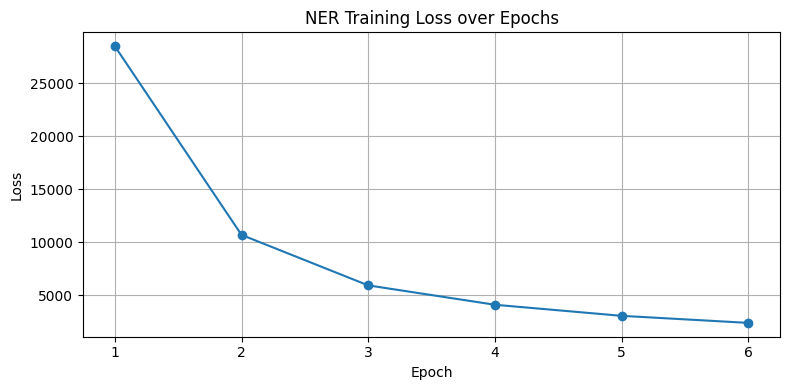

✅ Model saved to '02_Model/4m_ner_model_v4_de_core_news_lg_6_epochs'


In [39]:
import spacy
import random
from spacy.util import minibatch
from spacy.training.example import Example
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# === Load training data ===
import json

training_data_path = "03_Label/spacy_training_data_sentences_v5_new_data.json"
with open(training_data_path, "r", encoding="utf-8") as f:
    raw_data = json.load(f) 

# Convert to spaCy Examples
training_data = [
    (item["text"], {"entities": [tuple(ent) for ent in item["entities"]]})
    for item in raw_data
]

nlp = spacy.load("de_core_news_lg")

examples = []
for text, annotations in training_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    examples.append(example)

print(f"✅ Converted {len(examples)} examples")

# === Add NER labels ===
ner = nlp.get_pipe("ner")
for example in examples:
    for ent in example.reference.ents:
        ner.add_label(ent.label_)

# === Train without .initialize() ===
loss_history = []
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.resume_training()
    for epoch in range(6):
        random.shuffle(examples)
        losses = {}
        batches = list(minibatch(examples, size=64))
        for batch in tqdm(batches, desc=f"Epoch {epoch+1}", leave=False):
            nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)
        print(f"Epoch {epoch+1} Loss: {losses}")
        loss_history.append(losses.get("ner", 0))

# === Plot loss ===
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker="o")
plt.title("NER Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Save model ===
model_name = f"02_Model/4m_ner_model_v4_de_core_news_lg_{epoch+1}_epochs"
nlp.to_disk(model_name)
print(f"✅ Model saved to '{model_name}'")


Add EntityRuler

In [8]:
import spacy
import json
from spacy.pipeline import EntityRuler

# === Modell laden (z. B. dein trainiertes Modell) ===
nlp = spacy.load("02_Model/4m_ner_model_v4_de_core_news_lg_10_epochs")

# === Labels aus JSON laden ===
with open("03_Label/gemeinden_labels_v4.json", "r", encoding="utf-8") as f:
    label_data = json.load(f)

# === EntityRuler erstellen ===
ruler = EntityRuler(nlp, overwrite_ents=False)

# === Muster hinzufügen ===
for entry in label_data:
    label_text = entry["label"]
    pattern = {"label": "LOC", "pattern": label_text}
    ruler.add_patterns([pattern])

# === EntityRuler ins Pipeline einfügen (vor dem NER-Modell) ===
nlp.add_pipe("entity_ruler", before="ner", config={"validate": True})
nlp.get_pipe("entity_ruler").add_patterns(ruler.patterns)

# === Neues Modell speichern ===
output_path = "02_Model/4m_ner_model_v4_plus_entityruler"
nlp.to_disk(output_path)
print(f"✅ Modell mit EntityRuler gespeichert unter: {output_path}")


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:339: UserWarning: [W012] A Doc object you're adding to the PhraseMatcher for pattern 'LOC' is parsed and/or tagged, but to match on 'ORTH', you don't actually need this information. This means that creating the patterns is potentially much slower, because all pipeline components are applied. To only create tokenized Doc objects, try using `nlp.make_doc(text)` or process all texts as a stream using `list(nlp.tokenizer.pipe(all_texts))`.
  self.phrase_matcher.add(label, [pattern])  # type: ignore


✅ Modell mit EntityRuler gespeichert unter: 02_Model/4m_ner_model_v4_plus_entityruler


#### Comparison

In [1]:
version = "v4"
labels_json = f"03_Label/gemeinden_labels_{version}.json"
statistic_dataset = "05_Statistik/Statistischer_Test_Datensatz_v1.csv"
comparison_csv = f"05_Statistik/statistical_test_dataset_data_{version}.csv"

In [2]:
import pandas as pd
import json
import re
import spacy
import time
from transformers import pipeline

# --- Dateien einlesen ---
df = pd.read_csv(statistic_dataset)

with open(labels_json, "r", encoding="utf-8") as f:
    categorized_labels = json.load(f)

# --- Regex vorbereiten ---
label_list = sorted([entry["label"] for entry in categorized_labels], key=len, reverse=True)
pattern = r'(?<!\w)(' + '|'.join(re.escape(label) for label in label_list) + r')(?!\w)'
label_regex = re.compile(pattern)

def find_labels(text):
    if pd.isna(text):
        return []
    return list(set(label_regex.findall(text)))

# --- spaCy-Modelle laden ---
nlp_custom = spacy.load("02_Model/4m_ner_model_v4_de_core_news_lg_6_epochs")
nlp_base = spacy.load("de_core_news_lg")

def extract_spacy_entities(text, model):
    if pd.isna(text):
        return []
    doc = model(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# --- HuggingFace BERT-NER laden ---
pipe_bert = pipeline("token-classification", model="mschiesser/ner-bert-german", aggregation_strategy="simple")

def extract_bert_entities(text):
    if pd.isna(text) or not text.strip():
        return []
    try:
        entities = pipe_bert(text)
        
        # Nur 'LOC' Entitäten extrahieren und Subwörter zusammenfügen
        loc_entities = []
        current_entity = ""
        for ent in entities:
            if ent['entity_group'] == 'LOC':
                word = ent['word']
                # Wenn das Wort mit '##' beginnt, ist es ein Subwort und wird zum vorherigen Wort hinzugefügt
                if word.startswith("##"):
                    current_entity += word[2:]
                else:
                    # Wenn ein vollständiges Wort gefunden wird, füge das vorherige zusammengefügte Wort und das neue Wort zur Liste hinzu
                    if current_entity:
                        loc_entities.append(current_entity)
                    current_entity = word
        
        # Füge das letzte zusammengefügte Wort hinzu (falls vorhanden)
        if current_entity:
            loc_entities.append(current_entity)
        
        return loc_entities
    
    except Exception as e:
        return [("ERROR", str(e))]



# --- Ergebnislisten und Zeitstoppuhr ---
re_labels_list = []
custom_entities_list = []
base_entities_list = []
bert_entities_list = []

# --- Zeitmessung für Regex ---
start_re = time.perf_counter()
for _, row in df.iterrows():
    title = str(row.get("dataset_title_de", ""))
    desc = str(row.get("dataset_description_de", ""))
    re_labels_list.append(list(set(find_labels(title) + find_labels(desc))))
end_re = time.perf_counter()

# --- Zeitmessung für spaCy Custom ---
start_custom = time.perf_counter()
for _, row in df.iterrows():
    text = f"{row.get('dataset_title_de', '')} {row.get('dataset_description_de', '')}"
    custom_entities_list.append(extract_spacy_entities(text, nlp_custom))
end_custom = time.perf_counter()

# --- Zeitmessung für spaCy Base ---
start_base = time.perf_counter()
for _, row in df.iterrows():
    text = f"{row.get('dataset_title_de', '')} {row.get('dataset_description_de', '')}"
    base_entities_list.append(extract_spacy_entities(text, nlp_base))
end_base = time.perf_counter()

# --- Zeitmessung für BERT NER ---
start_bert = time.perf_counter()
for _, row in df.iterrows():
    text = f"{row.get('dataset_title_de', '')} {row.get('dataset_description_de', '')}"
    bert_entities_list.append(extract_bert_entities(text))
end_bert = time.perf_counter()

# --- In DataFrame einfügen ---
df["re_matched_labels"] = re_labels_list
df["spacy_custom_LOC_labels"] = custom_entities_list
df["spacy_base_LOC_labels"] = base_entities_list
df["bert_ner_labels"] = bert_entities_list

# --- Zeiten berechnen ---
total_re_time = end_re - start_re
total_custom_time = end_custom - start_custom
total_base_time = end_base - start_base
total_bert_time = end_bert - start_bert

# --- Zeit-Ausgabe ---
print("Verarbeitungszeiten (gesamt):")
print(f"  Regex:         {total_re_time:.3f} Sekunden")
print(f"  spaCy Custom:  {total_custom_time:.3f} Sekunden")
print(f"  spaCy Base:    {total_base_time:.3f} Sekunden")
print(f"  BERT NER:      {total_bert_time:.3f} Sekunden")

# --- Als CSV speichern ---
df.to_csv(comparison_csv, index=False, encoding="utf-8")


Device set to use cpu


Verarbeitungszeiten (gesamt):
  Regex:         1.428 Sekunden
  spaCy Custom:  1.714 Sekunden
  spaCy Base:    1.621 Sekunden
  BERT NER:      31.440 Sekunden


Clean matches

In [3]:
import pandas as pd
import ast

# Load CSV
df = pd.read_csv(comparison_csv)

# 1. Convert to list, and replace [] → ['not_found']
def to_list_with_not_found(value):
    if isinstance(value, list):
        return value if value else ['not_found']
    if pd.isna(value) or str(value).strip() == "":
        return ['not_found']
    items = [item.strip() for item in str(value).strip("[]").split(",") if item.strip()]
    return items if items else ['not_found']

df["correct_location"] = df["correct_location"].apply(to_list_with_not_found)
df["semantic_location"] = df["semantic_location"].apply(to_list_with_not_found)
df["re_matched_labels"] = df["re_matched_labels"].apply(
    lambda x: to_list_with_not_found(ast.literal_eval(x)) if isinstance(x, str) else to_list_with_not_found(x)
)
df["bert_ner_labels"] = df["bert_ner_labels"].apply(
    lambda x: to_list_with_not_found(ast.literal_eval(x)) if isinstance(x, str) else to_list_with_not_found(x)
)

# 2. If spaCy LOC labels are not already cleaned: parse and extract LOCs
if isinstance(df["spacy_custom_LOC_labels"].iloc[0], list) and not isinstance(df["spacy_custom_LOC_labels"].iloc[0][0], tuple):
    print("✅ spaCy LOC-Spalten enthalten bereits extrahierte Textwerte.")
else:
    def safe_literal_eval_list_of_tuples(val):
        try:
            result = ast.literal_eval(val)
            if isinstance(result, list) and all(isinstance(item, tuple) and len(item) == 2 for item in result):
                return result
        except Exception:
            pass
        return []

    def extract_loc_texts(entity_list):
        return [text for text, label in entity_list if label == "LOC"]

    df["spacy_custom_LOC_labels"] = df["spacy_custom_LOC_labels"].apply(safe_literal_eval_list_of_tuples).apply(extract_loc_texts)
    df["spacy_base_LOC_labels"] = df["spacy_base_LOC_labels"].apply(safe_literal_eval_list_of_tuples).apply(extract_loc_texts)


# 4. Remove the word "Gemeinde" from all relevant columns
columns_to_clean = [
    "correct_location",
    "re_matched_labels",
    "spacy_custom_LOC_labels",
    "spacy_base_LOC_labels",
    "bert_ner_labels"
]

def remove_gemeinde(label_list):
    return [label.replace("Gemeinde", "").strip() for label in label_list]

for col in columns_to_clean:
    df[col] = df[col].apply(remove_gemeinde)

# 5. Remove duplicates in each column
duplicats_to_remove = columns_to_clean  # gleich wie oben

def remove_duplicates(label_list):
    try:
        return list(dict.fromkeys(label_list))
    except:
        return label_list

for col in duplicats_to_remove:
    df[col] = df[col].apply(remove_duplicates)

# NaN ersetzen
df["dataset_title_de"] = df["dataset_title_de"].fillna("")
df["dataset_description_de"] = df["dataset_description_de"].fillna("")

# Hilfsfunktion zum Entfernen einzelner Satzzeichen
def clean_text(text):
    # Entfernt alle Zeichen außer Buchstaben, Zahlen und Leerzeichen
    return re.sub(r"[^\wäöüÄÖÜß\s]", "", text)

# Bereinigen und zusammenführen
df["all_words"] = (df["dataset_title_de"].apply(clean_text) + " " + df["dataset_description_de"].apply(clean_text)).str.split()


# 6. Save cleaned data
df.to_csv(comparison_csv, index=False, encoding="utf-8")


In [4]:
import pandas as pd
import ast

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === Liste erzwingen ===
def force_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

for col in ["correct_location", "re_matched_labels", "spacy_custom_LOC_labels", "spacy_base_LOC_labels", "bert_ner_labels", "all_words"]:
    df[col] = df[col].apply(force_list)

# === Normalisierung: Kleinbuchstaben & trim ===
def normalize_list(liste):
    return [str(item).strip().lower() for item in liste if isinstance(item, str)]

# === Vokabular aus all_words sammeln ===
all_labels = set()
df["all_words"] = df["all_words"].apply(normalize_list)
df["all_words"].apply(lambda lst: all_labels.update(lst))

# === Metriken mit vollständigem Labelraum berechnen ===
def precision_recall_f1_accuracy(predicted, actual, label_space):
    pred_set = set(normalize_list(predicted))
    actual_set = set(normalize_list(actual))
    
    tp = len(pred_set & actual_set)
    fp = len(pred_set - actual_set)
    fn = len(actual_set - pred_set)
    tn = len(label_space - pred_set - actual_set)

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0

    return precision, recall, f1, accuracy

# === Modellspalten definieren ===
model_columns = {
    "regex": "re_matched_labels",
    "custom": "spacy_custom_LOC_labels",
    "base": "spacy_base_LOC_labels",
    "ner_bert": "bert_ner_labels",
}

# === Berechnung auf alle Zeilen anwenden ===
for variant, col in model_columns.items():
    df[[f"precision_{variant}", f"recall_{variant}", f"f1_{variant}", f"accuracy_{variant}"]] = df.apply(
        lambda row: pd.Series(
            precision_recall_f1_accuracy(row[col], row["correct_location"], all_labels)
        ),
        axis=1
    )

# === Ergebnisse wieder ins Original-CSV speichern ===
df.to_csv(comparison_csv, index=False, encoding="utf-8")

# === Durchschnittswerte als Tabelle erzeugen ===
summary_data = []
for variant in model_columns.keys():
    summary_data.append({
        "Methode": variant.upper(),
        "Precision": df[f"precision_{variant}"].mean(),
        "Recall": df[f"recall_{variant}"].mean(),
        "F1-Score": df[f"f1_{variant}"].mean(),
        "Accuracy": df[f"accuracy_{variant}"].mean()
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(3)

# === Pfad zum Speichern der Score-Tabelle ===
summary_path = f"05_Statistik/loc_scores_summary_{version}.csv"
summary_df.to_csv(summary_path, index=False, encoding="utf-8")

# === Ausgabe im Terminal ===
print(f"\n✅ Durchschnittliche Scores gespeichert unter: {summary_path}")
print("\n📊 Durchschnittliche Scores je Modell:")
print(summary_df)



✅ Durchschnittliche Scores gespeichert unter: 05_Statistik/loc_scores_summary_v4.csv

📊 Durchschnittliche Scores je Modell:
    Methode  Precision  Recall  F1-Score  Accuracy
0     REGEX      0.818   0.825     0.808     1.000
1    CUSTOM      0.618   0.647     0.619     1.000
2      BASE      0.372   0.531     0.412     0.999
3  NER_BERT      0.413   0.482     0.425     0.999


🖼️ Tabelle gespeichert unter: 05_Statistik/loc_scores_tabelle_v4.png


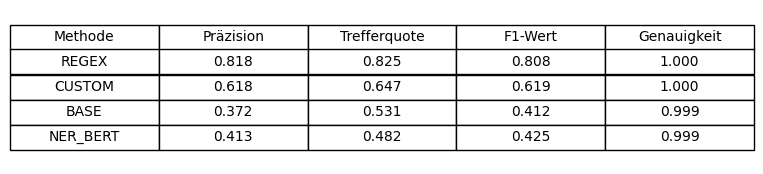

In [5]:
import matplotlib.pyplot as plt

# === Deutsche Spaltennamen definieren ===
summary_df_de = summary_df.rename(columns={
    "Methode": "Methode",
    "Precision": "Präzision",
    "Recall": "Trefferquote",   # oder "Erinnerung" je nach Kontext
    "F1-Score": "F1-Wert",
    "Accuracy": "Genauigkeit"
})

# === Werte als Strings mit genau 3 Nachkommastellen formatieren ===
formatted_values = summary_df_de.applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x).values

# === Tabelle als Grafik darstellen ===
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(
    cellText=formatted_values,
    colLabels=summary_df_de.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# === Grafikpfad definieren ===
table_image_path = f"05_Statistik/loc_scores_tabelle_{version}.png"

# === Grafik speichern ===
plt.savefig(table_image_path, bbox_inches='tight', dpi=300)
print(f"🖼️ Tabelle gespeichert unter: {table_image_path}")

# === Optional: Anzeige im Notebook/Fenster ===
plt.show()


✅ Konfusionsmatrix gespeichert unter: 05_Statistik/konfusionsmatrizen_loc_erkennung_data_v4.png


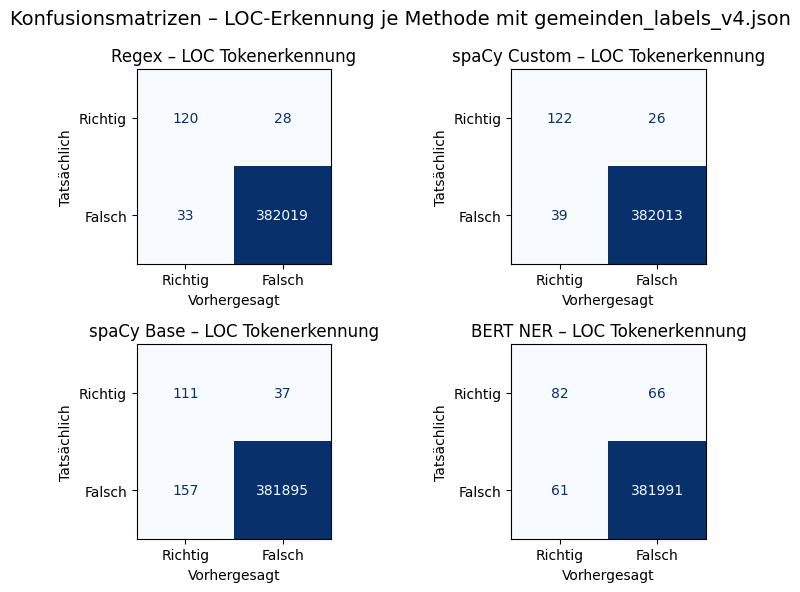

✅ Precision/Recall/F1 gespeichert unter: 05_Statistik/loc_scores_data_v4.csv


In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import ast
import os

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === Pfade zum Speichern ===
image_path = f"05_Statistik/konfusionsmatrizen_loc_erkennung_data_{version}.png"
score_path = f"05_Statistik/loc_scores_data_{version}.csv"

# === Helfer: String -> Liste ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

for col in ["correct_location", "re_matched_labels", "spacy_custom_LOC_labels", "spacy_base_LOC_labels", "bert_ner_labels", "all_words"]:
    df[col] = df[col].apply(to_list)

# === Alle möglichen Labels bestimmen (für False–False-Fälle) ===
all_labels = set()
df["all_words"] = df["all_words"].apply(lambda lst: [str(item).strip().lower() for item in lst])
df["all_words"].apply(lambda lst: all_labels.update(lst))

# === Token-Ebene Vergleich unter Berücksichtigung aller Labels ===
def get_true_pred_pairs_full(df, pred_col, all_labels):
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        true_set = set(map(str.lower, row["correct_location"]))
        pred_set = set(map(str.lower, row[pred_col]))
        for label in all_labels:
            y_true.append(label in true_set)
            y_pred.append(label in pred_set)
    return y_true, y_pred

# === Modelle definieren ===
variants = {
    "Regex": "re_matched_labels",
    "spaCy Custom": "spacy_custom_LOC_labels",
    "spaCy Base": "spacy_base_LOC_labels",
    "BERT NER": "bert_ner_labels"
}

# === Subplot-Setup ===
n_rows = (len(variants) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 3 * n_rows))
axes = axes.flatten()

results = []

# === Matritzen und Scores berechnen ===
for idx, (name, col) in enumerate(variants.items()):
    y_true, y_pred = get_true_pred_pairs_full(df, col, all_labels)
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Richtig", "Falsch"])
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(f"{name} – LOC Tokenerkennung")
    axes[idx].set_xlabel("Vorhergesagt")
    axes[idx].set_ylabel("Tatsächlich")

    # Scores berechnen
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    results.append({"Methode": name, "Precision": precision, "Recall": recall, "F1-Score": f1})

# === Grafik speichern ===
plt.suptitle(f"Konfusionsmatrizen – LOC-Erkennung je Methode mit gemeinden_labels_{version}.json", fontsize=14)
plt.tight_layout()
plt.savefig(image_path, dpi=300)
print(f"✅ Konfusionsmatrix gespeichert unter: {image_path}")

# === Grafik anzeigen ===
plt.show()

# === Scores speichern ===
score_df = pd.DataFrame(results)
score_df.to_csv(score_path, index=False)
print(f"✅ Precision/Recall/F1 gespeichert unter: {score_path}")


Minium one right

In [7]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === String → Liste konvertieren ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

cols_to_fix = ["correct_location", "re_matched_labels", "spacy_custom_LOC_labels", "spacy_base_LOC_labels","bert_ner_labels"]
for col in cols_to_fix:
    df[col] = df[col].apply(to_list)

# === Erfolgskriterium: Mindestens ein korrektes Label erkannt ===
def has_success(correct, predicted):
    correct_set = set(x.lower() for x in correct if x != "not_found")
    pred_set = set(x.lower() for x in predicted if x != "not_found")
    return not correct_set.isdisjoint(pred_set)

df["success_regex"] = df.apply(lambda row: has_success(row["correct_location"], row["re_matched_labels"]), axis=1)
df["success_custom"] = df.apply(lambda row: has_success(row["correct_location"], row["spacy_custom_LOC_labels"]), axis=1)
df["success_base"] = df.apply(lambda row: has_success(row["correct_location"], row["spacy_base_LOC_labels"]), axis=1)
df["success_bert"] = df.apply(lambda row: has_success(row["correct_location"], row["bert_ner_labels"]), axis=1)

# === Erfolgsquote berechnen ===
success_rates = {
    "Regex": df["success_regex"].mean(),
    "spaCy Custom": df["success_custom"].mean(),
    "spaCy Base": df["success_base"].mean(),
    "Bert NER": df["success_bert"].mean()

}

# === Grafik erstellen ===
plt.figure(figsize=(8, 4))
plt.bar(success_rates.keys(), success_rates.values(), color=["#4c72b0", "#55a868", "#c44e52"])
plt.title(f"Erfolgsrate pro Datensatz – LOC-Erkennung (Version {version})")
plt.ylabel("Erfolgsrate (mind. 1 korrektes Label)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# === Grafik speichern ===
erfolg_plot_path = f"05_Statistik/erfolgsrate_pro_datensatz_{version}.png"
plt.savefig(erfolg_plot_path, dpi=300)
plt.close()

print(f"✅ Erfolgs-Grafik gespeichert unter: {erfolg_plot_path}")

# === Erfolgsraten auch als CSV speichern (optional) ===
pd.DataFrame([success_rates]).to_csv(f"05_Statistik/loc_erfolg_pro_datensatz_{version}.csv", index=False)
print(f"✅ Erfolgswerte als CSV gespeichert.")


✅ Erfolgs-Grafik gespeichert unter: 05_Statistik/erfolgsrate_pro_datensatz_v4.png
✅ Erfolgswerte als CSV gespeichert.


Where the Model is better than regex

In [8]:
# === Vergleich: Fehlerhafte Regex, aber korrekte spaCy Custom ===

def normalize(val):
    return sorted(str(x).lower().strip() for x in val if x != 'not_found')

# Bedingungen definieren
mask = df.apply(lambda row: (
    normalize(row["re_matched_labels"]) != normalize(row["correct_location"]) and
    normalize(row["spacy_custom_LOC_labels"]) == normalize(row["correct_location"])
), axis=1)

# Gefilterte Zeilen anzeigen
df_filtered = df[mask][["dataset_title_de", "dataset_description_de", "correct_location", "re_matched_labels", "spacy_custom_LOC_labels"]]

# Ausgabe
print("\n🔍 Fälle, bei denen Regex falsch lag, aber spaCy Custom korrekt war:\n")
for _, row in df_filtered.iterrows():
    print(f"📌 Titel: {row['dataset_title_de']}")
    print(f"📝 Beschreibung: {row['dataset_description_de']}")
    print(f"✅ Erwartet: {row['correct_location']}")
    print(f"❌ Regex:    {row['re_matched_labels']}")
    print(f"✔️ spaCy:    {row['spacy_custom_LOC_labels']}")
    print("-" * 80)



🔍 Fälle, bei denen Regex falsch lag, aber spaCy Custom korrekt war:

📌 Titel: KLARA-Standorte
📝 Beschreibung: Standorte der Kleinst-Abwasserreinigungsanlagen (KLARA) im Kanton St.Gallen., Download der Geodaten
✅ Erwartet: ['Kanton St.Gallen']
❌ Regex:    ['not_found']
✔️ spaCy:    ['Kanton St.Gallen']
--------------------------------------------------------------------------------
📌 Titel: Züri wie neu
📝 Beschreibung: Züri wie neu Meldungen: Gemeldet werden können sämtliche Schäden an der Infrastruktur der Stadt Zürich. Dabei kann es sich um ein Loch im Strassenbelag, ein Graffiti am Stadthaus oder eine durch Vandalen beschädigte Parkbank handeln.
✅ Erwartet: ['Züri', 'Stadt Zürich']
❌ Regex:    ['Stadt Zürich']
✔️ spaCy:    ['Züri', 'Stadt Zürich']
--------------------------------------------------------------------------------
📌 Titel: Kulturgüterschutzinventar mit Objekten von nationaler Bedeutung (TG)
📝 Beschreibung: Kulturgüterschutzinventar mit Objekten von nationaler Bedeutung,

Regex is better than the costume model

In [9]:
# === Vergleich: Fehlerhafte spaCy Custom, aber korrekte Regex ===

def normalize(val):
    return sorted(str(x).lower().strip() for x in val if x != 'not_found')

# Neue Bedingung
mask = df.apply(lambda row: (
    normalize(row["spacy_custom_LOC_labels"]) != normalize(row["correct_location"]) and
    normalize(row["re_matched_labels"]) == normalize(row["correct_location"])
), axis=1)

# Gefilterte Zeilen
df_filtered = df[mask][[
    "dataset_title_de", "dataset_description_de", "correct_location",
    "re_matched_labels", "spacy_custom_LOC_labels"
]]

# Ausgabe
print("\n🔍 Fälle, bei denen spaCy Custom falsch lag, aber Regex korrekt war:\n")
for _, row in df_filtered.iterrows():
    print(f"📌 Titel: {row['dataset_title_de']}")
    print(f"📝 Beschreibung: {row['dataset_description_de']}")
    print(f"✅ Erwartet: {row['correct_location']}")
    print(f"✔️ Regex:    {row['re_matched_labels']}")
    print(f"❌ spaCy:    {row['spacy_custom_LOC_labels']}")
    print("-" * 80)



🔍 Fälle, bei denen spaCy Custom falsch lag, aber Regex korrekt war:

📌 Titel: Kaltbrunn - Sondernutzungspläne, kommunal projektiert Kt SG
📝 Beschreibung: neues kantonales Modell (xtf)Diese Karte zeigt die projektierten kommunalen Sondernutzungspläne an. Es werden unter anderem die Perimeter der Baulinienpläne, Gestaltungspläne, Quartierpläne, Überbauungspläne, Deponiepläne und Abbaupläne dargestellt.
✅ Erwartet: ['Kt SG', 'Kaltbrunn']
✔️ Regex:    ['Kt SG', 'Kaltbrunn']
❌ spaCy:    ['Kaltbrunn', 'SG']
--------------------------------------------------------------------------------
📌 Titel: Gemeinde Mühleberg - Amtliche Vermessung (AV)
📝 Beschreibung: Die amtliche Vermessung informiert über Grundstücke, Bodenbedeckung, Gebäudeadressen und weitere Informationsebenen, die zur Anlage und Führung des Grundbuchs dienen.Details zu den einzelnen AV-Informationsebenen der Gemeinde Mühleberg siehe verlinkte Ressourcen.Qualitätsstandard der AV in der Gemeinde Mühleberg:- AV93, definitiv anerkann

#### Fuzzy matching

In [10]:
import json
from fuzzywuzzy import process, fuzz

# === JSON mit Labels laden ===
with open("03_Label/gemeinden_labels_v4.json", "r", encoding="utf-8") as f:
    label_data = json.load(f)

# Liste der Labelnamen extrahieren
label_texts = [entry["label"] for entry in label_data]

# Korrigierte Matching-Funktion
def find_best_label_match(term, cutoff=80):
    match, score = process.extractOne(term, label_texts, scorer=fuzz.ratio)
    if score >= cutoff:
        return next(entry for entry in label_data if entry["label"] == match)
    return 


In [11]:
test_words = ["AV", "Gde", "Energieetiketten", "Baugesuche","Tiefenbeschränkungen","Ausserortsbereichen","Schutzzonenplan","Davös"]

for word in test_words:
    match = find_best_label_match(word, cutoff=80)
    if match:
        print(f"🔍 {word} → {match['label']} (ID: {match['label_id']})")
    else:
        print(f"❌ {word} → keine Übereinstimmung")


❌ AV → keine Übereinstimmung
🔍 Gde → GE (ID: CH2500000000)
❌ Energieetiketten → keine Übereinstimmung
❌ Baugesuche → keine Übereinstimmung
❌ Tiefenbeschränkungen → keine Übereinstimmung
❌ Ausserortsbereichen → keine Übereinstimmung
❌ Schutzzonenplan → keine Übereinstimmung
🔍 Davös → Davos (ID: CH18184900000)


In [12]:
import json
from fuzzywuzzy import process, fuzz

# Load label list from JSON
with open("03_Label/gemeinden_labels_v4.json", "r", encoding="utf-8") as f:
    label_data = json.load(f)

# Extract list of valid labels
label_texts = [entry["label"] for entry in label_data]

# Fuzzy matcher: returns full JSON match or None
def find_best_label_match(term, cutoff=80):
    match, score = process.extractOne(term, label_texts, scorer=fuzz.ratio)
    if score >= cutoff:
        return next(entry for entry in label_data if entry["label"] == match)
    return None


In [13]:
def match_label_list(label_list):
    matches = []
    for label in label_list:
        match = find_best_label_match(label)
        matches.append(match["label"] if match else None)
    return matches


# Apply to column
df["spacy_custom_LOC_matches"] = df["spacy_custom_LOC_labels"].apply(match_label_list)
df.to_csv(comparison_csv, index=False, encoding="utf-8")



KeyError: 'success_spacy_custom'

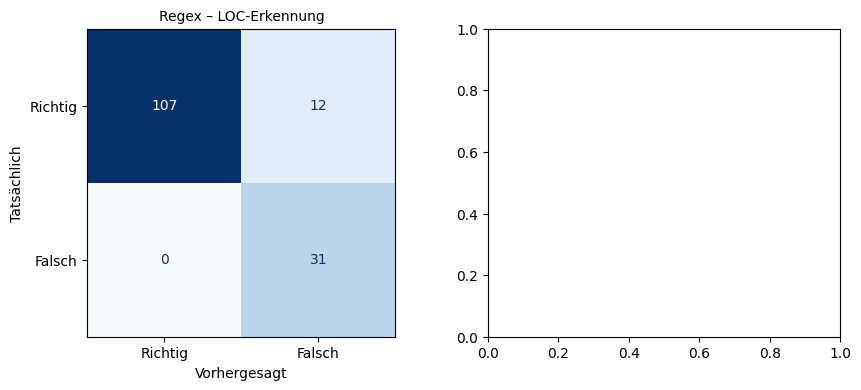

In [14]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === String → Liste konvertieren ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

cols_to_fix = ["correct_location", "re_matched_labels", "spacy_custom_LOC_matches", "all_words"]
for col in cols_to_fix:
    df[col] = df[col].apply(to_list)

# === Erfolgskriterium: Mindestens ein korrektes Label erkannt ===
def has_success(correct, predicted):
    correct_set = set(x.lower() for x in correct if x and x != "not_found")
    pred_set = set(x.lower() for x in predicted if x and x != "not_found")
    return not correct_set.isdisjoint(pred_set)

df["success_regex"] = df.apply(lambda row: has_success(row["correct_location"], row["re_matched_labels"]), axis=1)
df["success_custom"] = df.apply(lambda row: has_success(row["correct_location"], row["spacy_custom_LOC_matches"]), axis=1)

# === Erwartung: Gibt es mindestens ein korrektes Label?
def expected_to_match(correct_labels):
    return any(x and x != "not_found" for x in correct_labels)

df["expected"] = df["correct_location"].apply(expected_to_match)

# === Hilfsfunktion: true/predicted extrahieren
def get_true_pred_pairs(df, success_column):
    y_true = df["expected"]
    y_pred = df[success_column]
    return y_true, y_pred

# === Varianten definieren
variants = {
    "Regex": "success_regex",
    "spaCy Custom": "success_custom"
}


# === Plot vorbereiten
fig, axes = plt.subplots(1, len(variants), figsize=(10, 4))
results = []

# === Konfusionsmatrizen + Scores plotten
for idx, (name, col) in enumerate(variants.items()):
    y_true, y_pred = get_true_pred_pairs(df, col)
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Richtig", "Falsch"])
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(f"{name} – LOC-Erkennung", fontsize=10)
    axes[idx].set_xlabel("Vorhergesagt")
    axes[idx].set_ylabel("Tatsächlich")

    # Scores (Dokumentebene)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # === FN-Berechnung auf Tokenebene ===
    fn_tokens = 0
    for _, row in df[df["expected"]].iterrows():
        correct_set = set(x.lower() for x in row["correct_location"] if x and x != "not_found")
        pred_set = set(x.lower() for x in row[pred_col] if x and x != "not_found")
        all_words = set(x.lower() for x in row["all_words"])
        for token in all_words:
            if token in correct_set and token not in pred_set:
                fn_tokens += 1

    # Ergebnisse speichern
    results.append({
        "Methode": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "False Negatives (Token)": fn_tokens
    })

# === Layout & speichern
plt.suptitle(f"Konfusionsmatrizen – LOC-Erkennung (Version {version})", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
image_path = f"05_Statistik/conf_matrix_LOC_{version}.png"
plt.savefig(image_path, dpi=300)
plt.show()
print(f"✅ Konfusionsmatrix gespeichert unter: {image_path}")

# === Scores speichern
score_df = pd.DataFrame(results)
score_path = f"05_Statistik/precision_recall_f1_FN_LOC_{version}.csv"
score_df.to_csv(score_path, index=False)
print(f"✅ Precision/Recall/F1 + FN gespeichert unter: {score_path}")


### Test with custom text

In [ ]:
# import spacy
# nlp_custom = spacy.load("02_Model/4m_ner_model_v4_plus_entityruler")
# pipe_bert = pipeline("token-classification", model="mschiesser/ner-bert-german", aggregation_strategy="simple")
# nlp_base = spacy.load("de_core_news_lg")

In [ ]:
# import re
# import spacy
# from transformers import pipeline
# import json

# # --- Labels vorbereiten ---
# def load_labels(labels_json):
#     with open(labels_json, "r", encoding="utf-8") as f:
#         categorized_labels = json.load(f)
#     label_list = sorted([entry["label"] for entry in categorized_labels], key=len, reverse=True)
#     pattern = r'(?<!\w)(' + '|'.join(re.escape(label) for label in label_list) + r')(?!\w)'
#     label_regex = re.compile(pattern)
#     return label_regex

# # --- Regex Modell ---
# def find_labels(text, label_regex):
#     if pd.isna(text):
#         return []
#     return list(set(label_regex.findall(text)))

# # --- spaCy Modelle ---


# def extract_spacy_entities(text, model):
#     if pd.isna(text):
#         return []
#     doc = model(text)
#     return [(ent.text, ent.label_) for ent in doc.ents]

# # --- BERT NER Modell ---


# def extract_bert_entities(text, pipe_bert):
#     if pd.isna(text) or not text.strip():
#         return []
#     try:
#         entities = pipe_bert(text)
#         loc_entities = []
#         current_entity = ""
#         for ent in entities:
#             if ent['entity_group'] == 'LOC':
#                 word = ent['word']
#                 if word.startswith("##"):
#                     current_entity += word[2:]
#                 else:
#                     if current_entity:
#                         loc_entities.append(current_entity)
#                     current_entity = word
#         if current_entity:
#             loc_entities.append(current_entity)
#         return loc_entities
#     except Exception as e:
#         return [("ERROR", str(e))]

# # --- Einfaches Beispiel: Eingabe und Label finden ---
# def find_labels_for_text(text, label_regex, nlp_custom, nlp_base, pipe_bert):
#     # Regex
#     regex_labels = find_labels(text, label_regex)
    
#     # spaCy Custom
#     custom_entities = extract_spacy_entities(text, nlp_custom)
    
#     # spaCy Base
#     base_entities = extract_spacy_entities(text, nlp_base)
    
#     # BERT NER
#     bert_entities = extract_bert_entities(text, pipe_bert)

#     # Ausgabe der Ergebnisse
#     print("Eingabetext: ", text)
#     print("\nRegex Labels: ", regex_labels)
#     print("\nspaCy Custom Labels: ", custom_entities)
#     print("\nspaCy Base Labels: ", base_entities)
#     print("\nBERT NER Labels: ", bert_entities)

# # --- Hauptcode ---
# text_input = "Der Zürcher Wein ist gut!"

# # Modelle laden
# label_regex = load_labels(labels_json)

# # Labels für den Text finden
# find_labels_for_text(text_input, label_regex, nlp_custom, nlp_base, pipe_bert)


### Performance of Made up labels

In [ ]:
# import pandas as pd
# import json
# import re
# import spacy
# import time
# from transformers import pipeline

# # --- Dateien einlesen ---
# df = pd.read_csv("05_Statistik/made_up_labels_v1.csv")  # Neue Datei einlesen

# with open(labels_json, "r", encoding="utf-8") as f:
#     categorized_labels = json.load(f)

# # --- Regex vorbereiten ---
# label_list = sorted([entry["label"] for entry in categorized_labels], key=len, reverse=True)
# pattern = r'(?<!\w)(' + '|'.join(re.escape(label) for label in label_list) + r')(?!\w)'
# label_regex = re.compile(pattern)

# def find_labels(text):
#     if pd.isna(text):
#         return []
#     return list(set(label_regex.findall(text)))

# # --- spaCy-Modelle laden ---
# nlp_custom = spacy.load("02_Model/4m_ner_model_v4_plus_entityruler")
# nlp_base = spacy.load("de_core_news_lg")

# def extract_spacy_entities(text, model):
#     if pd.isna(text):
#         return []
#     doc = model(text)
#     return [(ent.text, ent.label_) for ent in doc.ents]

# # --- HuggingFace BERT-NER laden ---
# pipe_bert = pipeline("token-classification", model="mschiesser/ner-bert-german", aggregation_strategy="simple")

# def extract_bert_entities(text):
#     if pd.isna(text) or not text.strip():
#         return []
#     try:
#         entities = pipe_bert(text)
        
#         # Nur 'LOC' Entitäten extrahieren und Subwörter zusammenfügen
#         loc_entities = []
#         current_entity = ""
#         for ent in entities:
#             if ent['entity_group'] == 'LOC':
#                 word = ent['word']
#                 if word.startswith("##"):
#                     current_entity += word[2:]
#                 else:
#                     if current_entity:
#                         loc_entities.append(current_entity)
#                     current_entity = word
        
#         if current_entity:
#             loc_entities.append(current_entity)
        
#         return loc_entities
    
#     except Exception as e:
#         return [("ERROR", str(e))]

# # --- Ergebnislisten und Zeitstoppuhr ---
# re_labels_list = []
# custom_entities_list = []
# base_entities_list = []
# bert_entities_list = []

# # --- Zeitmessung für Regex ---
# start_re = time.perf_counter()
# for _, row in df.iterrows():
#     text = str(row.get("text"))
#     re_labels_list.append(list(set(find_labels(text) )))
# end_re = time.perf_counter()

# # --- Zeitmessung für spaCy Custom ---
# start_custom = time.perf_counter()
# for _, row in df.iterrows():
#     text = f"{row.get('text', '')}"
#     custom_entities_list.append(extract_spacy_entities(text, nlp_custom))
# end_custom = time.perf_counter()

# # --- Zeitmessung für spaCy Base ---
# start_base = time.perf_counter()
# for _, row in df.iterrows():
#     text = f"{row.get('text', '')}"
#     base_entities_list.append(extract_spacy_entities(text, nlp_base))
# end_base = time.perf_counter()

# # --- Zeitmessung für BERT NER ---
# start_bert = time.perf_counter()
# for _, row in df.iterrows():
#     text = f"{row.get('text', '')}"
#     bert_entities_list.append(extract_bert_entities(text))
# end_bert = time.perf_counter()

# # --- In DataFrame einfügen ---
# df["re_matched_labels"] = re_labels_list
# df["spacy_custom_LOC_labels"] = custom_entities_list
# df["spacy_base_LOC_labels"] = base_entities_list
# df["bert_ner_labels"] = bert_entities_list

# # --- Zeiten berechnen ---
# total_re_time = end_re - start_re
# total_custom_time = end_custom - start_custom
# total_base_time = end_base - start_base
# total_bert_time = end_bert - start_bert

# # --- Zeit-Ausgabe ---
# print("Verarbeitungszeiten (gesamt):")
# print(f"  Regex:         {total_re_time:.3f} Sekunden")
# print(f"  spaCy Custom:  {total_custom_time:.3f} Sekunden")
# print(f"  spaCy Base:    {total_base_time:.3f} Sekunden")
# print(f"  BERT NER:      {total_bert_time:.3f} Sekunden")

# # --- Als CSV speichern ---
# df.to_csv("05_Statistik/made_up_labels_with_results.csv", index=False, encoding="utf-8")
